# Imports

In [1]:
import os, sys
import kagglehub
import polars as pl
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy
import numpy as np
import torch
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
import torch.nn as nn

In [2]:
src_abspath = os.path.abspath('..')

if src_abspath not in sys.path:
    sys.path.append(src_abspath)

In [3]:
from src.autoencoders.models import MLPAutoencoder, ConvAutoencoder, ConvBiLSTMAutoencoder, save_model_full, load_model_full
from src.autoencoders.train_loops import train_model_generic
from src.autoencoders.datasets import MAFAULDADataset

# Data

In [4]:
DATA_PATH = kagglehub.dataset_download("vuxuancu/mafaulda-full")

print("Path to dataset files:", DATA_PATH)

Download already complete (13157899016 bytes).
Extracting files...
Path to dataset files: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1


In [5]:
OUTPUT_DIR = '../pictures/MAFAULDA'
FS = 50000          # Частота дискретизации
DURATION_LOAD = 3   # Секунд для анализа
MAX_FREQ_VIEW = 1000
WINDOW_SIZE = 1024
STRIDE = 512
USE_CHANNELS = [1] 

channel_names = {
    1: "Underhang - Axial",
    2: "Underhang - Radial",
    3: "Underhang - Tangential",
    4: "Overhang - Axial",
    5: "Overhang - Radial",
    6: "Overhang - Tangential",
    7: "Microphone"
}

normal_files = glob.glob(os.path.join(DATA_PATH, 'mafaulda/normal/*.csv'))

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 📚 Описание датасета MAFAULDA

**MAFAULDA** (Machinery Fault Database) — это набор многомерных временных рядов, полученных с экспериментального стенда **SpectraQuest Machinery Fault Simulator (MFS)**. Данные предоставлены Лабораторией сигналов, мультимедиа и телекоммуникаций (SMT) университета UFRJ.

Датасет содержит **1951** запись длительностью по 5 секунд каждая.

## 🛠 1. Параметры экспериментальной установки

*   **Двигатель:** 1/4 CV DC
*   **Диапазон скоростей вращения:** $700 - 3600$ об/мин (RPM)
*   **Частота дискретизации ($F_s$):** $50\,000$ Гц (50 кГц)
*   **Длительность записи:** 5 секунд ($250\,000$ точек на канал)
*   **Подшипники:** Шариковые (8 шариков, диаметр шарика $0.7145$ см)

---

## 📡 2. Расположение датчиков (Channel Mapping)

Файлы датасета содержат 8 колонок. Ниже приведена таблица соответствия индексов Python (0-based) физическим датчикам:

| Index (Python) | Тип датчика | Расположение | Направление | Примечание |
| :---: | :--- | :--- | :--- | :--- |
| **0** | **Tachometer** | Вал | - | Используется для точного расчета RPM |
| **1** | Accelerometer | Underhang (Внутр.) | Axial (Осевое) | |
| **2** | **Accelerometer** | **Underhang (Внутр.)** | **Radial (Радиальное)** | Лучший для дисбаланса/подшипников |
| **3** | Accelerometer | Underhang (Внутр.) | Tangential (Танг.) | |
| **4** | Accelerometer | Overhang (Внешн.) | Axial (Осевое) | |
| **5** | **Accelerometer** | **Overhang (Внешн.)** | **Radial (Радиальное)** | Лучший для дисбаланса/подшипников |
| **6** | Accelerometer | Overhang (Внешн.) | Tangential (Танг.) | |
| **7** | Microphone | - | - | Акустический сигнал |

> *Примечание: **Underhang** — подшипник между мотором и ротором. **Overhang** — внешний подшипник (ротор между мотором и ним).*

---

## ⚠️ 3. Типы симулируемых неисправностей

Датасет включает 6 состояний системы:
1.  **Normal:** Нормальная работа (49 последовательностей).
2.  **Imbalance:** Дисбаланс ротора (нагрузки 6–35 г).
3.  **Horizontal Misalignment:** Горизонтальная расцентровка (0.5–2.0 мм).
4.  **Vertical Misalignment:** Вертикальная расцентровка (0.51–1.90 мм).
5.  **Underhang Bearing Faults:** Дефекты внутреннего подшипника (внешняя обойма, шарики, внутренняя обойма).
6.  **Overhang Bearing Faults:** Дефекты внешнего подшипника.

---

## 🧮 4. Характеристические частоты подшипников

Для диагностики подшипников используются следующие кинематические частоты (где $f_r$ — частота вращения вала в Гц):

*   **FTF (Cage)** — Частота сепаратора:
    $$f_{FTF} = 0.3750 \times f_r$$

*   **BSF (Ball)** — Частота вращения тел качения (шариков):
    $$f_{BSF} = 1.8710 \times f_r$$

*   **BPFO (Outer Race)** — Частота переката по внешней обойме:
    $$f_{BPFO} = 2.9980 \times f_r$$

*   **BPFI (Inner Race)** — Частота переката по внутренней обойме:
    $$f_{BPFI} = 5.0020 \times f_r$$

---

# EDA

In [7]:
def get_rpm_robust(tach_signal, fs=50000):
    # 1. Проверяем размах сигнала
    sig_min = np.min(tach_signal)
    sig_max = np.max(tach_signal)
    peak_to_peak = sig_max - sig_min
    
    # Если сигнал "мbертвый" (шум < 0.1 вольта условно), то RPM = 0
    # В датасете значения могут быть нормализованы, поэтому порог эмпирический
    if peak_to_peak < 0.1: 
        return 0.0

    # 2. Определяем ориентацию импульсов
    # Если max отклоняется от среднего сильнее, чем min -> импульсы вверх
    # Если min отклоняется сильнее -> импульсы вниз
    mean_val = np.mean(tach_signal)
    
    if abs(sig_max - mean_val) > abs(sig_min - mean_val):
        # Импульсы вверх (Positive logic)
        # Порог ставим на 60% высоты
        threshold = mean_val + 0.6 * (sig_max - mean_val)
        peaks, _ = scipy.signal.find_peaks(tach_signal, height=threshold, distance=fs//100)
    else:
        # Импульсы вниз (Negative logic) - инвертируем сигнал для поиска
        inv_signal = -tach_signal
        inv_max = -sig_min # max инвертированного равен -min исходного
        inv_mean = -mean_val
        
        threshold = inv_mean + 0.6 * (inv_max - inv_mean)
        peaks, _ = scipy.signal.find_peaks(inv_signal, height=threshold, distance=fs//100)

    # 3. Считаем RPM
    if len(peaks) < 2:
        return 0.0
        
    avg_diff = np.mean(np.diff(peaks))
    rpm = (fs / avg_diff) * 60
    return rpm



In [7]:
N_points = int(FS * DURATION_LOAD)
window_global = scipy.signal.get_window('hann', N_points)

for f_path in tqdm(normal_files, desc="Processing"):
    try:
        filename = os.path.basename(f_path)
        meas_num = ''.join(filter(str.isdigit, filename))
        if not meas_num: meas_num = "Unknown"
        
        df = pl.read_csv(
            f_path, 
            has_header=False, 
            n_rows=N_points,
            separator=',' # Явно указываем разделитель
        )
        
        # Моментальная конвертация в Numpy для Scipy/Matplotlib
        # Polars делает это очень быстро (zero-copy, если типы совпадают)
        data = df.to_numpy()
        
        # Проверка, хватило ли данных (иногда файлы короче 3 секунд)
        real_len = len(data)
        if real_len < N_points:
            # Если файл короче, пересоздаем окно под реальный размер
            current_window = scipy.signal.get_window('hann', real_len)
        else:
            current_window = window_global

        # Расчет RPM (0-я колонка)
        rpm = get_rpm_robust(data[:, 0], FS)
        freq_1x = rpm / 60
        
        # Графики
        fig, axes = plt.subplots(7, 2, figsize=(16, 20))
        fig.suptitle(f"File: {filename} | RPM: {rpm:.1f} ({freq_1x:.1f} Hz)", fontsize=16, y=0.92)
        
        for ch_idx in range(1, 8):
            row = ch_idx - 1
            sig = data[:, ch_idx]
            
            # Remove DC
            sig = sig - np.mean(sig)
            
            # --- Time Domain ---
            snippet_len = int(0.05 * FS)
            # Защита от коротких файлов
            snippet_len = min(snippet_len, real_len)
            time_x = np.linspace(0, snippet_len/FS, snippet_len)
            
            ax_t = axes[row, 0]
            ax_t.plot(time_x, sig[:snippet_len], color='tab:blue', linewidth=0.8)
            ax_t.set_title(f"Ch {ch_idx}: {channel_names[ch_idx]}", fontsize=10, fontweight='bold')
            ax_t.set_ylabel("Amp")
            if row == 6: ax_t.set_xlabel("Time (s)")
            ax_t.grid(True, alpha=0.3)
            
            # --- Freq Domain ---
            fft_y = np.abs(scipy.fft.rfft(sig * current_window))
            fft_x = scipy.fft.rfftfreq(real_len, d=1/FS)
            fft_db = 20 * np.log10(fft_y + 1e-9)
            
            ax_f = axes[row, 1]
            ax_f.plot(fft_x, fft_db, color='tab:red', linewidth=0.8)
            
            if rpm > 100:
                ax_f.axvline(freq_1x, color='green', linestyle='--', alpha=0.7, label='1x RPM')
            
            ax_f.set_xlim(0, MAX_FREQ_VIEW)
            if row == 0 and rpm > 100: ax_f.legend(loc='upper right', fontsize=8)
            if row == 6: ax_f.set_xlabel("Freq (Hz)")
            ax_f.grid(True, alpha=0.3)

        plt.subplots_adjust(hspace=0.4)
        save_name = f"Normal_Meas{meas_num}_RPM{int(rpm)}.png"
        plt.savefig(os.path.join(OUTPUT_DIR, save_name), dpi=100, bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"Error {f_path}: {e}")

print("Done.")

Processing:   0%|          | 0/49 [00:00<?, ?it/s]

Done.


# Датасет

In [6]:
class MAFAULDADataset(Dataset):
    def __init__(self, file_paths, window_size=1024, stride=512, channels=[0, 1], 
                 mode='time', standardize=True, split_ratios=[0.7, 0.9], subset='all', scaler=None):
        
        self.mode = mode
        
        temp_samples = []
        for fp in file_paths:
            try:
                full = pl.read_csv(fp, has_header=False).to_numpy()
                idx1 = int(full.shape[0] * split_ratios[0])
                idx2 = int(full.shape[0] * split_ratios[1])
                
                if subset == 'train':   data = full[:idx1, channels]
                elif subset == 'val':   data = full[idx1:idx2, channels]
                elif subset == 'test':  data = full[idx2:, channels]
                else:                   data = full[:, channels]
                
                if data.shape[0] < window_size: continue
                
                # Нарезка окон
                for start in range(0, data.shape[0] - window_size + 1, stride):
                    temp_samples.append(data[start : start + window_size].T) # [Ch, Win]
            except Exception as e:
                print(f"Error {fp}: {e}")

        self.data = np.stack(temp_samples).astype(np.float32) if temp_samples else np.empty((0, len(channels), window_size), dtype=np.float32)
        
        # 2. Препроцессинг FFT (сразу для всего датасета)
        if self.mode == 'fft' and len(self.data) > 0:
            self.data -= self.data.mean(axis=-1, keepdims=True)
            self.data = np.log10(np.abs(np.fft.rfft(self.data, axis=2)) + 1e-6)

        # 3. Стандартизация через sklearn
        self.scaler = scaler
        if standardize and len(self.data) > 0:
            N, C, W = self.data.shape
            flat_data = self.data.reshape(N, -1)
            
            if self.scaler is None:
                self.scaler = StandardScaler()
                flat_data = self.scaler.fit_transform(flat_data)
            else:
                flat_data = self.scaler.transform(flat_data)
            
            # Возвращаем форму обратно
            self.data = flat_data.reshape(N, C, W).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.mode == 'fft':
            return torch.from_numpy(x.flatten())
        return torch.from_numpy(x)

# Обучение MLP(time) + Conv(time) + ConvBiLSTM(time)


📡 ОБУЧЕНИЕ НА КАНАЛЕ 2
--> MLP_Time_new (Ch 2)...


Train:   0%|          | 0/100 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 17, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch2.pt
Эпоха: 18, 💾 Моде

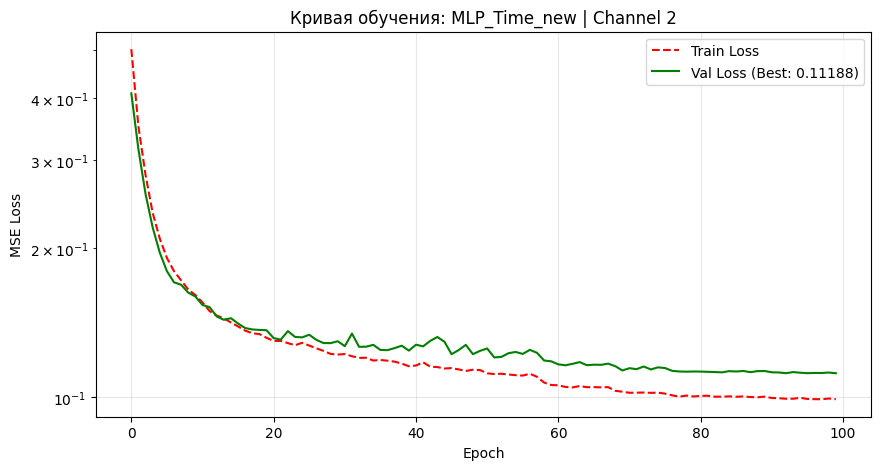

   Best Val Loss: 0.111884
--> ConvAE_new (Ch 2)...


Train:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 17, 💾 Модель сохранена: ../weights/ConvAE_new_Ch2.pt
Эпоха: 18, 💾 Модель сохранена: ../weights/ConvAE_

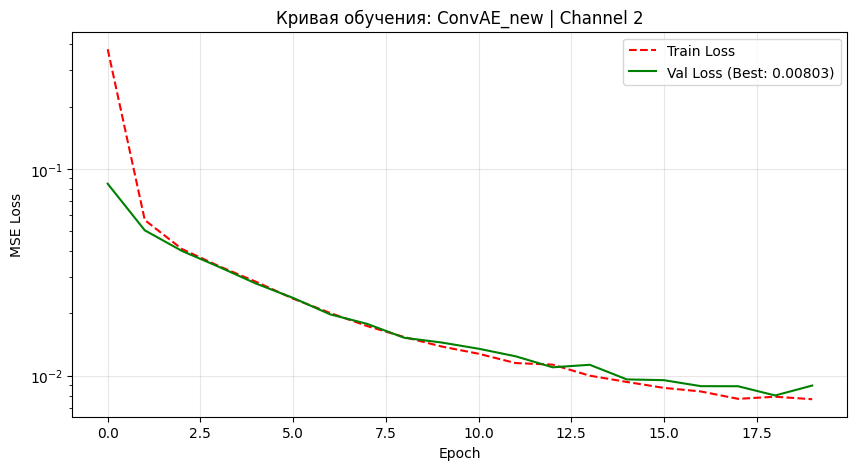

   Best Val Loss: 0.008028
--> ConvBiLSTM_new (Ch 2)...


Train:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch2.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/ConvBiL

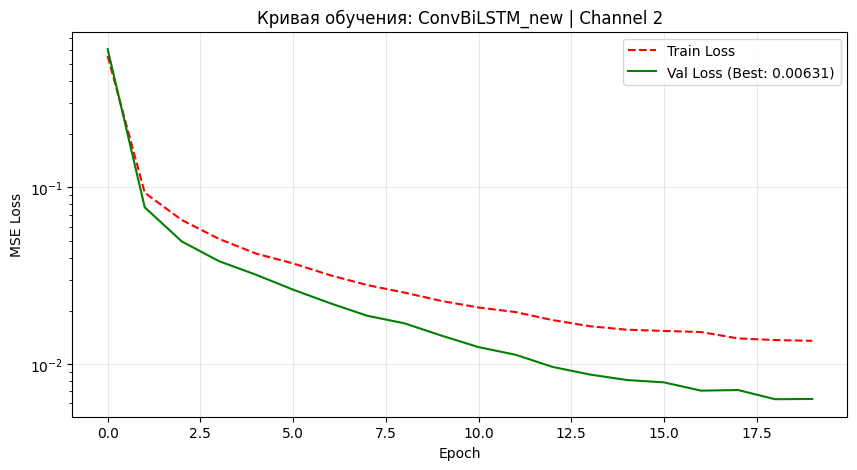

   Best Val Loss: 0.006310

📡 ОБУЧЕНИЕ НА КАНАЛЕ 5
--> MLP_Time_new (Ch 5)...


Train:   0%|          | 0/100 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 17, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 20, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 22, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 23, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 25, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 26, 💾 Модель сохранена: ../weights/MLP_Time_new_Ch5.pt
Эпоха: 30, 💾 Мо

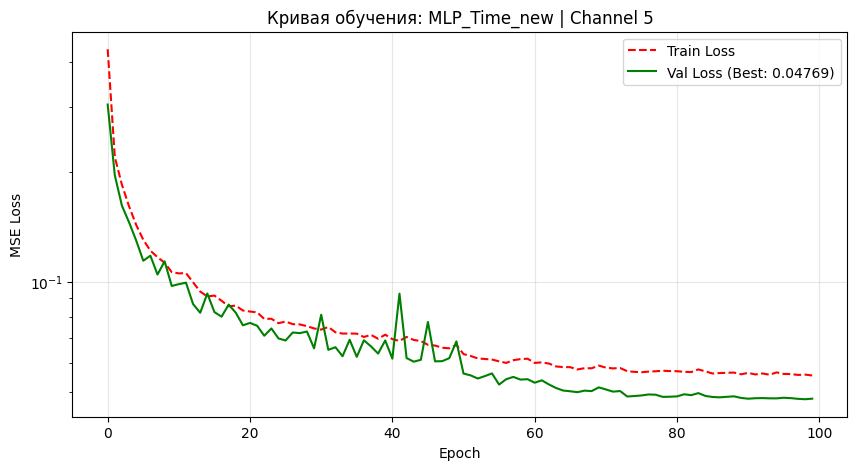

   Best Val Loss: 0.047686
--> ConvAE_new (Ch 5)...


Train:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 17, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
Эпоха: 18, 💾 Модель сохранена: ../weights/ConvAE_new_Ch5.pt
   📈 График сохранен: ../pictures/models/ConvAE_new_Ch5_curve.png


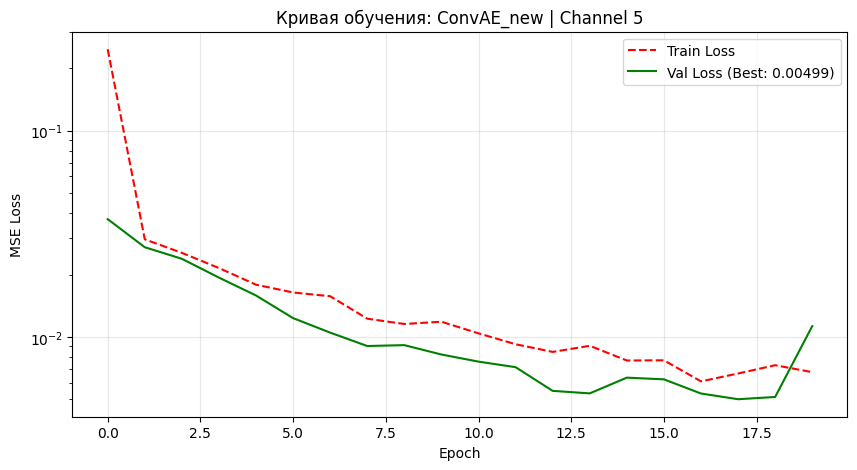

   Best Val Loss: 0.004987
--> ConvBiLSTM_new (Ch 5)...


Train:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 17, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
Эпоха: 19, 💾 Модель сохранена: ../weights/ConvBiLSTM_new_Ch5.pt
   📈 График сохранен: ../pictures/models/ConvBiLSTM_new_Ch5_curve.png


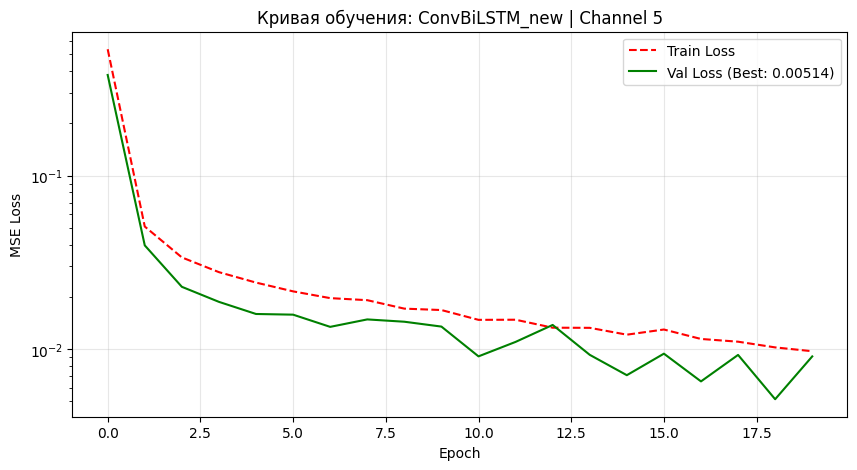

   Best Val Loss: 0.005144

Готово.


In [10]:
TARGET_CHANNELS = [2, 5] # Берем радиальние данние
WINDOW_SIZE = 1024
STRIDE = 512
DEVICE = 'cpu'
IMG_SAVE_DIR = '../pictures/models'
os.makedirs(IMG_SAVE_DIR, exist_ok=True)


configs = {
    "MLP_Time_new": {
        "class": MLPAutoencoder,
        "params": {
            "input_shape": (1, WINDOW_SIZE), 
            "latent_dim": 256,
            "hidden_dims": [1024, 512],
            "dropout": 0.05,
            "batchnorm": True,
            "activation": nn.LeakyReLU
        },
        "epochs": 100,
        "lr": 1e-3
    },
    "ConvAE_new": {
        "class": ConvAutoencoder,
        "params": {
            "in_channels": 1,
            "window_size": WINDOW_SIZE,
            "activation": nn.LeakyReLU
        },
        "epochs": 20,
        "lr": 1e-3
    },
    "ConvBiLSTM_new": {
        "class": ConvBiLSTMAutoencoder,
        "params": {
            "in_channels": 1, 
            "window_size": WINDOW_SIZE,
            "latent_dim": 64 
        },
        "epochs": 20,
        "lr": 1e-3
    }
}

for ch in TARGET_CHANNELS:
    print(f"\n{'='*30}\n📡 ОБУЧЕНИЕ НА КАНАЛЕ {ch}\n{'='*30}")
    
    ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='time', subset='train')
    ds_val   = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='time', subset='val', scaler=ds_train.scaler)
    
    dl_train = DataLoader(ds_train, batch_size=512, shuffle=True)
    dl_val   = DataLoader(ds_val, batch_size=512, shuffle=False)
    
    # 2. Прогон по моделям
    for model_name, cfg in configs.items():
        print(f"--> {model_name} (Ch {ch})...")
        
        # Инициализация (всегда 1 канал на входе)
        model = cfg["class"](**cfg["params"])
        epochs = cfg["epochs"]

        lr = cfg["lr"]
        
        # Имя файла: ConvAE_Ch2.pt
        save_path = f"../weights/{model_name}_Ch{ch}.pt"
        
        # Запуск обучения
        hist = train_model_generic(
            model=model,
            model_params=cfg["params"],
            train_loader=dl_train,
            val_loader=dl_val,
            num_epochs=epochs,
            device=DEVICE,
            save_path=save_path,
            lr=lr
        )
        
        best_loss = min(hist['val_loss'])
        plt.figure(figsize=(10, 5)) # Создаем новую фигуру для каждой модели!
        plt.plot(hist["train_loss"], label="Train Loss", linestyle="--", c="red")
        plt.plot(hist["val_loss"], label=f"Val Loss (Best: {best_loss:.5f})", c="green")
        
        plt.title(f"Кривая обучения: {model_name} | Channel {ch}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.yscale('log') # Для Loss часто лучше логарифмическая шкала
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        img_filename = f"{model_name}_Ch{ch}_curve.png"
        img_full_path = os.path.join(IMG_SAVE_DIR, img_filename)
        
        plt.savefig(img_full_path, dpi=100, bbox_inches='tight')
        print(f"   📈 График сохранен: {img_full_path}")
        
        plt.show()
        
        print(f"   Best Val Loss: {min(hist['val_loss']):.6f}")
print("\nГотово.")

# Обучение MLP(spectral)


📡 ОБУЧЕНИЕ НА КАНАЛЕ 2
--> MLP_fft_new (Ch 2)...


Train:   0%|          | 0/100 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch2.pt
Эпоха: 17, 💾 Модель сохранена: ..

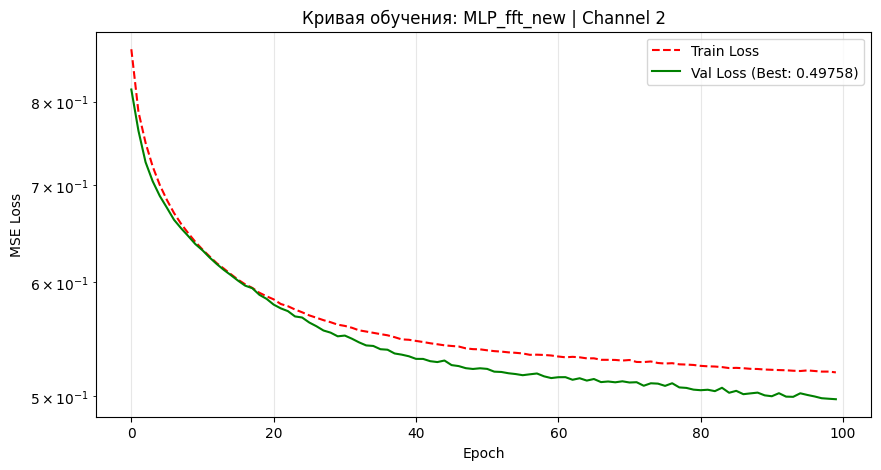

   Best Val Loss: 0.497584

📡 ОБУЧЕНИЕ НА КАНАЛЕ 5
--> MLP_fft_new (Ch 5)...


Train:   0%|          | 0/100 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/MLP_fft_new_Ch5.pt
Эпоха: 17, 💾 Модель сохранена: ..

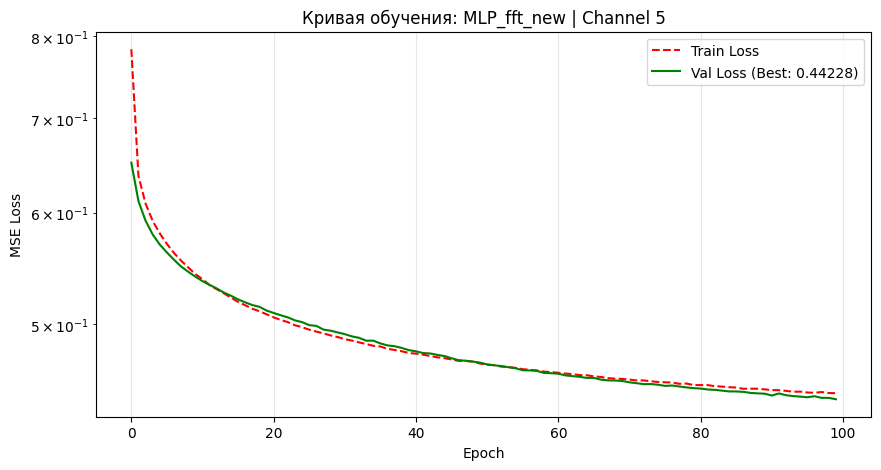

   Best Val Loss: 0.442283


In [9]:
TARGET_CHANNELS = [2, 5] # Берем радиальние данние
WINDOW_SIZE = 1024
STRIDE = 512
DEVICE = 'cpu'
IMG_SAVE_DIR = '../pictures/models'
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

configs_fft = {
    "MLP_fft_new": {
        "class": MLPAutoencoder,
        "params": {
            "input_shape": (WINDOW_SIZE // 2 + 1,), 
            "latent_dim": 192,
            "hidden_dims": [512, 256],
            "dropout": 0.05,
            "batchnorm": True,
            "activation": nn.LeakyReLU
        },
        "epochs": 100,
        "lr": 1e-3
    }
}

for ch in TARGET_CHANNELS:
    print(f"\n{'='*30}\n📡 ОБУЧЕНИЕ НА КАНАЛЕ {ch}\n{'='*30}")
    
    # 1. Создаем датасеты ТОЛЬКО для текущего канала
    # subset='train'/'val' берет начало/конец файла (как обсудили)
    ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='fft', subset='train')
    ds_val   = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='fft', subset='val', scaler=ds_train.scaler)
    
    dl_train = DataLoader(ds_train, batch_size=512, shuffle=True)
    dl_val   = DataLoader(ds_val, batch_size=512, shuffle=False)
    
    # 2. Прогон по моделям
    for model_name, cfg in configs_fft.items():
        print(f"--> {model_name} (Ch {ch})...")
        
        # Инициализация (всегда 1 канал на входе)
        model = cfg["class"](**cfg["params"])
        epochs = cfg["epochs"]
        
        save_path = f"../weights/{model_name}_Ch{ch}.pt"
        
        # Запуск обучения
        hist = train_model_generic(
            model=model,
            model_params=cfg["params"],
            train_loader=dl_train,
            val_loader=dl_val,
            num_epochs=epochs,
            device=DEVICE,
            save_path=save_path,
            lr=cfg["lr"]
        )
        best_loss = min(hist['val_loss'])
        plt.figure(figsize=(10, 5)) # Создаем новую фигуру для каждой модели!
        plt.plot(hist["train_loss"], label="Train Loss", linestyle="--", c="red")
        plt.plot(hist["val_loss"], label=f"Val Loss (Best: {best_loss:.5f})", c="green")
        
        plt.title(f"Кривая обучения: {model_name} | Channel {ch}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.yscale('log') # Для Loss часто лучше логарифмическая шкала
        plt.legend()
        plt.grid(True, alpha=0.3)

        img_filename = f"{model_name}_Ch{ch}_curve.png"
        img_full_path = os.path.join(IMG_SAVE_DIR, img_filename)
        
        plt.savefig(img_full_path, dpi=100, bbox_inches='tight')
        print(f"   📈 График сохранен: {img_full_path}")
        
        plt.show()
        
        print(f"   Best Val Loss: {min(hist['val_loss']):.6f}")
    



📡 ОБУЧЕНИЕ НА КАНАЛЕ 2
--> ConvAE_fft_new (Ch 2)...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch2.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/ConvAE_

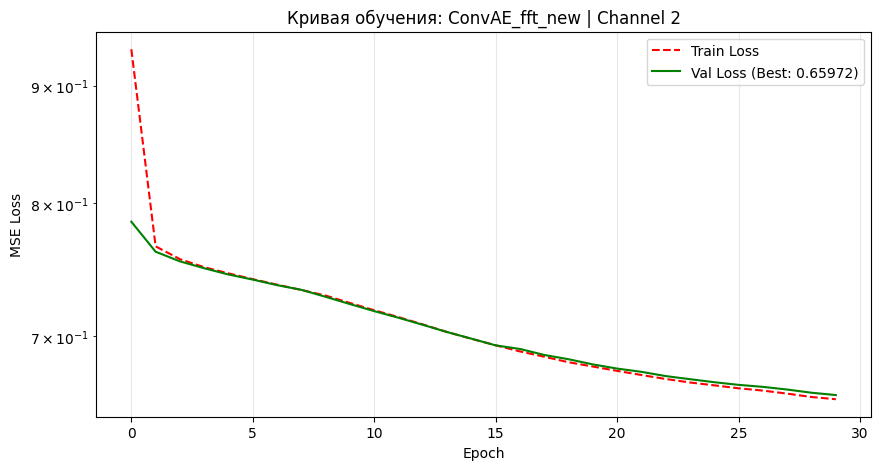

   Best Val Loss: 0.659717
--> ConvBiLSTM_fft_new (Ch 2)...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch2.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_

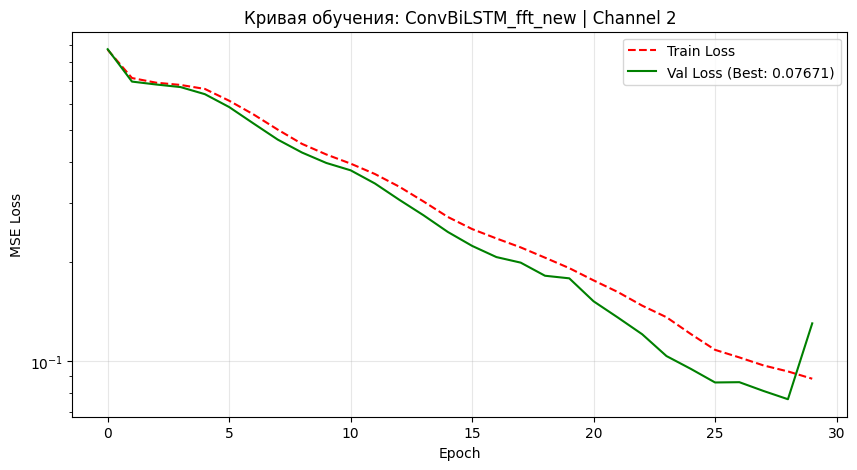

   Best Val Loss: 0.076707

📡 ОБУЧЕНИЕ НА КАНАЛЕ 5
--> ConvAE_fft_new (Ch 5)...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvAE_fft_new_Ch5.pt
Эпоха: 16, 💾 Модель сохранена: ../weights/ConvAE_

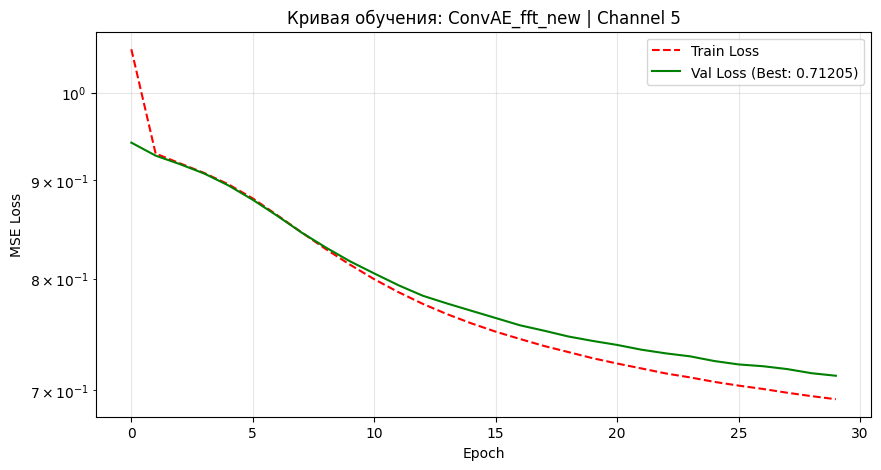

   Best Val Loss: 0.712049
--> ConvBiLSTM_fft_new (Ch 5)...


Train:   0%|          | 0/30 [00:00<?, ?it/s]

Эпоха: 1, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 2, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 3, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 4, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 5, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 6, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 7, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 8, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 9, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 10, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 11, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 12, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 13, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 14, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_new_Ch5.pt
Эпоха: 15, 💾 Модель сохранена: ../weights/ConvBiLSTM_fft_

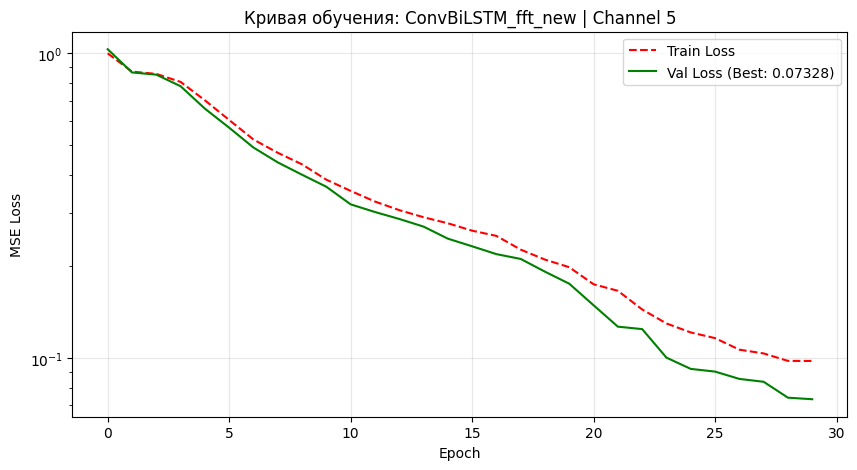

   Best Val Loss: 0.073284


In [7]:
TARGET_CHANNELS = [2, 5] # Берем радиальние данние
WINDOW_SIZE = 1024
STRIDE = 512
DEVICE = 'cpu'
IMG_SAVE_DIR = '../pictures/models'
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

configs_fft = {
    "ConvAE_fft_new": {
        "class": ConvAutoencoder,
        "params": {
            "in_channels": 1,
            "window_size": WINDOW_SIZE // 2 + 1,
            "activation": nn.LeakyReLU
        },
        "epochs": 30,
        "lr": 1e-3
    },
    "ConvBiLSTM_fft_new": {
        "class": ConvBiLSTMAutoencoder,
        "params": {
            "in_channels": 1, 
            "window_size": WINDOW_SIZE // 2 + 1,
            "latent_dim": 64 
        },
        "epochs": 30,
        "lr": 1e-3
    }
}

for ch in TARGET_CHANNELS:
    print(f"\n{'='*30}\n📡 ОБУЧЕНИЕ НА КАНАЛЕ {ch}\n{'='*30}")
    
    # 1. Создаем датасеты ТОЛЬКО для текущего канала
    # subset='train'/'val' берет начало/конец файла (как обсудили)
    ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='fft', subset='train')
    ds_val   = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, [ch], mode='fft', subset='val', scaler=ds_train.scaler)
    
    dl_train = DataLoader(ds_train, batch_size=512, shuffle=True)
    dl_val   = DataLoader(ds_val, batch_size=512, shuffle=False)
    
    # 2. Прогон по моделям
    for model_name, cfg in configs_fft.items():
        print(f"--> {model_name} (Ch {ch})...")
        
        # Инициализация (всегда 1 канал на входе)
        model = cfg["class"](**cfg["params"])
        epochs = cfg["epochs"]
        
        save_path = f"../weights/{model_name}_Ch{ch}.pt"
        
        # Запуск обучения
        hist = train_model_generic(
            model=model,
            model_params=cfg["params"],
            train_loader=dl_train,
            val_loader=dl_val,
            num_epochs=epochs,
            device=DEVICE,
            save_path=save_path,
            lr=cfg["lr"]
        )
        best_loss = min(hist['val_loss'])
        plt.figure(figsize=(10, 5)) # Создаем новую фигуру для каждой модели!
        plt.plot(hist["train_loss"], label="Train Loss", linestyle="--", c="red")
        plt.plot(hist["val_loss"], label=f"Val Loss (Best: {best_loss:.5f})", c="green")
        
        plt.title(f"Кривая обучения: {model_name} | Channel {ch}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.yscale('log') # Для Loss часто лучше логарифмическая шкала
        plt.legend()
        plt.grid(True, alpha=0.3)

        img_filename = f"{model_name}_Ch{ch}_curve.png"
        img_full_path = os.path.join(IMG_SAVE_DIR, img_filename)
        
        plt.savefig(img_full_path, dpi=100, bbox_inches='tight')
        print(f"   📈 График сохранен: {img_full_path}")
        
        plt.show()
        
        print(f"   Best Val Loss: {min(hist['val_loss']):.6f}")
    


# Общая постановка эксперимента

In [7]:
fault_dirs = {}
for root, dir_, filenames in os.walk(DATA_PATH):
    if filenames:
        rel_path = os.path.relpath(root, DATA_PATH).split(os.sep)
        curr_dict = fault_dirs
        for el in rel_path:
            if el != '.':
                curr_dict = curr_dict.setdefault(el, {})
        curr_dict['files'] = filenames
        curr_dict['lf'] = pl.scan_csv(os.path.join(root, '*.csv'), has_header=False)

In [8]:
fault_dirs

{'mafaulda': {'horizontal-misalignment': {'0.5mm': {'files': ['12.288.csv',
     '13.5168.csv',
     '14.5408.csv',
     '15.36.csv',
     '16.384.csv',
     '17.408.csv',
     '18.8416.csv',
     '19.6608.csv',
     '20.48.csv',
     '21.504.csv',
     '22.528.csv',
     '23.552.csv',
     '24.3712.csv',
     '24.7808.csv',
     '25.8048.csv',
     '26.8288.csv',
     '28.672.csv',
     '29.2864.csv',
     '30.3104.csv',
     '31.5392.csv',
     '32.3584.csv',
     '33.1776.csv',
     '34.2016.csv',
     '35.2256.csv',
     '36.6592.csv',
     '37.888.csv',
     '38.5024.csv',
     '39.1168.csv',
     '40.3456.csv',
     '41.984.csv',
     '42.5984.csv',
     '43.008.csv',
     '44.2368.csv',
     '44.8512.csv',
     '46.8992.csv',
     '47.7184.csv',
     '48.3328.csv',
     '49.5616.csv',
     '50.176.csv',
     '51.4048.csv',
     '52.224.csv',
     '53.248.csv',
     '54.4768.csv',
     '55.0912.csv',
     '56.1152.csv',
     '57.344.csv',
     '58.1632.csv',
     '59.8016.csv',
 

## Генерация картинок

In [9]:
def get_reconstruction_errors(model, dataloader, device='cuda'):
    model.eval()
    
    # Определяем обе функции потерь
    criterion_mse = nn.MSELoss(reduction='none')
    criterion_mae = nn.L1Loss(reduction='none')
    
    errors_mse = []
    errors_mae = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Вычисление ошибок'):
            batch = batch.to(device)
            
            x_hat, _ = model(batch)
            
            # --- Считаем MSE ---
            loss_tensor_mse = criterion_mse(x_hat, batch)
            # (Batch, Time, Channels) -> (Batch, -1) -> mean
            loss_per_sample_mse = loss_tensor_mse.view(loss_tensor_mse.shape[0], -1).mean(dim=1)
            errors_mse.extend(loss_per_sample_mse.cpu().numpy())

            # --- Считаем MAE ---
            loss_tensor_mae = criterion_mae(x_hat, batch)
            loss_per_sample_mae = loss_tensor_mae.view(loss_tensor_mae.shape[0], -1).mean(dim=1)
            errors_mae.extend(loss_per_sample_mae.cpu().numpy())
            
    return {'mse': np.array(errors_mse), 'mae': np.array(errors_mae)}

def full_test(dict_, model, window_size, stride, channels, mode, normal_errors_dict, scaler, rel_path='', device='cpu', model_name=''):
    """
    normal_errors_dict: словарь {'mse': np.array, 'mae': np.array} с ошибками на нормальном датасете
    """
    for key, val in dict_.items():
        if key == 'files':
            print(100 * '-')
            print(f"Processing: {rel_path}")
            
            files = [os.path.join(rel_path, f) for f in dict_[key]]
            
            # Создаем датасет
            ds_test = MAFAULDADataset(files, window_size, stride, channels, mode=mode, subset='test', split_ratios=[0.7, 0.9], scaler=scaler)
            
            # Проверка на пустоту
            if len(ds_test) == 0:
                print(f"Skipping empty dataset: {rel_path}")
                break
                
            dl_test = DataLoader(ds_test, batch_size=512, shuffle=False)
            
            # 1. Вычисляем ошибки (словарь с mse и mae) для ТЕКУЩЕГО набора
            current_errors_dict = get_reconstruction_errors(model, dl_test, device=device)
            
            if len(current_errors_dict['mse']) == 0:
                break

            # --- ПОДГОТОВКА ДАННЫХ И РАСЧЕТ МЕТРИК ---
            # Нам нужно посчитать ROC отдельно для MSE и для MAE
            metrics_results = {}
            
            for metric_name in ['mse', 'mae']:
                norm_err = normal_errors_dict[metric_name]
                curr_err = current_errors_dict[metric_name]
                
                y_true = np.concatenate([np.zeros(len(norm_err)), np.ones(len(curr_err))])
                y_scores = np.concatenate([norm_err, curr_err])
                
                fpr, tpr, _ = roc_curve(y_true, y_scores)
                roc_auc = auc(fpr, tpr)
                
                metrics_results[metric_name] = {
                    'fpr': fpr, 'tpr': tpr, 'auc': roc_auc,
                    'norm': norm_err, 'curr': curr_err
                }

            # --- ВИЗУАЛИЗАЦИЯ (3 графика в ряд) ---
            fig, ax = plt.subplots(1, 3, figsize=(24, 6))
            
            # Заголовок для всей фигуры
            folder_name = '/'.join(rel_path.split('/')[-2:])
            fig.suptitle(f"Anomaly Detection Report: {folder_name} Model: {model_name}", fontsize=16)

            # График 1: Гистограмма MSE
            res_mse = metrics_results['mse']
            ax[0].hist(res_mse['norm'], bins=100, alpha=0.5, label='Normal', density=True, color='green')
            ax[0].hist(res_mse['curr'], bins=100, alpha=0.5, label='Anomaly', density=True, color='red')
            ax[0].set_title(f"MSE Distribution")
            ax[0].set_xlabel("MSE Error")
            ax[0].set_ylabel("Density")
            ax[0].legend()
            ax[0].grid(True, alpha=0.3)

            # График 2: Гистограмма MAE
            res_mae = metrics_results['mae']
            ax[1].hist(res_mae['norm'], bins=100, alpha=0.5, label='Normal', density=True, color='green')
            ax[1].hist(res_mae['curr'], bins=100, alpha=0.5, label='Anomaly', density=True, color='orange')
            ax[1].set_title(f"MAE Distribution")
            ax[1].set_xlabel("MAE Error")
            ax[1].legend()
            ax[1].grid(True, alpha=0.3)
            
            # График 3: ROC-кривые (сравниваем MSE и MAE на одном графике)
            ax[2].plot(res_mse['fpr'], res_mse['tpr'], color='red', lw=2, 
                       label=f"MSE (AUC = {res_mse['auc']:.4f})")
            ax[2].plot(res_mae['fpr'], res_mae['tpr'], color='orange', lw=2, linestyle='--', 
                       label=f"MAE (AUC = {res_mae['auc']:.4f})")
            
            ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':') # Диагональ
            ax[2].set_xlim([0.0, 1.0])
            ax[2].set_ylim([0.0, 1.05])
            ax[2].set_xlabel('False Positive Rate')
            ax[2].set_ylabel('True Positive Rate')
            ax[2].set_title('ROC Curves Comparison')
            ax[2].legend(loc="lower right")
            ax[2].grid(True, alpha=0.3)
            
            # Сохранение
            safe_name = '_'.join(rel_path.split('/')[-2:])
            if not safe_name: safe_name = "root"
            
            os.makedirs('results_comprehensive', exist_ok=True)
            save_path = os.path.join('results_comprehensive', f"report_{model_name}_{'_'.join([str(c) for c in channels])}_{safe_name}.png")
            plt.savefig(save_path)
            plt.close()
            
            print(f"Saved Report -> {save_path} | MSE AUC: {res_mse['auc']:.4f} | MAE AUC: {res_mae['auc']:.4f}")
            break
            
        elif key != 'lf':
            # Рекурсивный вызов, передаем словарь normal_errors_dict
            full_test(dict_[key], model, window_size, stride, channels, mode, normal_errors_dict, scaler, os.path.join(rel_path, key), device, model_name=model_name)

In [17]:
models_config = {
    'MLPAE_FFT': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/MLP_fft_Ch2.pt', '../weights/MLP_fft_Ch5.pt'], "class": MLPAutoencoder},
    'MLPAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/MLP_Time_Ch2.pt', '../weights/MLP_Time_Ch5.pt'], "class": MLPAutoencoder},
    'ConvAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvAE_Ch2.pt', '../weights/ConvAE_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvBiLSTM_Ch2.pt', '../weights/ConvBiLSTM_Ch5.pt'], "class": ConvBiLSTMAutoencoder}
}

DEVICE = 'cpu'
WINDOW_SIZE = 1024
STRIDE = 512

for cfg_name, cfg in tqdm(models_config.items(), desc='Перебор моделей', leave=False):
    for ch, path in zip(cfg['channels'], cfg['model_paths']):
        model = load_model_full(path, cfg['class'])
        model.to(DEVICE)

        ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='train', split_ratios=[0.7, 0.9])

        ds_normal = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='test', split_ratios=[0.7, 0.9], scaler=ds_train.scaler)
        dl_normal = DataLoader(ds_normal, batch_size=512, shuffle=False)

        print("Computing baseline errors (MSE & MAE)...")
        normal_errors_dict = get_reconstruction_errors(model, dl_normal, device=DEVICE)
        full_test(
            dict_=fault_dirs, 
            model=model, 
            window_size=WINDOW_SIZE, 
            stride=STRIDE, 
            channels=ch, 
            mode=cfg['mode'], 
            normal_errors_dict=normal_errors_dict,
            scaler=ds_train.scaler,
            rel_path=DATA_PATH,
            device=DEVICE,
            model_name=cfg_name
        )

Перебор моделей:   0%|          | 0/4 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_horizontal-misalignment_0.5mm.png | MSE AUC: 0.9462 | MAE AUC: 0.9667
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_horizontal-misalignment_1.0mm.png | MSE AUC: 0.8658 | MAE AUC: 0.9041
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_horizontal-misalignment_1.5mm.png | MSE AUC: 0.9681 | MAE AUC: 0.9783
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_horizontal-misalignment_2.0mm.png | MSE AUC: 0.9988 | MAE AUC: 0.9995
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_10g.png | MSE AUC: 0.8184 | MAE AUC: 0.8802
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_15g.png | MSE AUC: 0.7435 | MAE AUC: 0.7693
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_20g.png | MSE AUC: 0.8024 | MAE AUC: 0.8183
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_25g.png | MSE AUC: 0.8375 | MAE AUC: 0.8658
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_30g.png | MSE AUC: 0.9024 | MAE AUC: 0.9256
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_35g.png | MSE AUC: 0.8429 | MAE AUC: 0.8591
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_imbalance_6g.png | MSE AUC: 0.7244 | MAE AUC: 0.7703
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 0.9998
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_20g.png | MSE AUC: 0.9999 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9971 | MAE AUC: 0.9973
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_0g.png | MSE AUC: 0.9988 | MAE AUC: 0.9921
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_20g.png | MSE AUC: 0.9970 | MAE AUC: 0.9848
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_35g.png | MSE AUC: 0.9940 | MAE AUC: 0.9700
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_6g.png | MSE AUC: 0.9943 | MAE AUC: 0.9818
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_0g.png | MSE AUC: 0.9999 | MAE AUC: 0.9994
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_20g.png | MSE AUC: 0.9994 | MAE AUC: 0.9964
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_35g.png | MSE AUC: 0.9957 | MAE AUC: 0.9760
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_6g.png | MSE AUC: 1.0000 | MAE AUC: 0.9990
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_0g.png | MSE AUC: 0.9804 | MAE AUC: 0.9819
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_20g.png | MSE AUC: 0.9711 | MAE AUC: 0.9705
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_35g.png | MSE AUC: 0.9771 | MAE AUC: 0.9827
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9705 | MAE AUC: 0.9701
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_0g.png | MSE AUC: 0.9363 | MAE AUC: 0.9604
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_20g.png | MSE AUC: 0.8860 | MAE AUC: 0.9027
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_35g.png | MSE AUC: 0.8718 | MAE AUC: 0.8861
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_cage_fault_6g.png | MSE AUC: 0.8917 | MAE AUC: 0.9078
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_0g.png | MSE AUC: 0.9721 | MAE AUC: 0.9807
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_20g.png | MSE AUC: 0.9306 | MAE AUC: 0.9426
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_35g.png | MSE AUC: 0.9139 | MAE AUC: 0.9273
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_outer_race_6g.png | MSE AUC: 0.9495 | MAE AUC: 0.9676
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_0.51mm.png | MSE AUC: 0.8749 | MAE AUC: 0.9086
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_0.63mm.png | MSE AUC: 0.8775 | MAE AUC: 0.9178
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_1.27mm.png | MSE AUC: 0.9441 | MAE AUC: 0.9685
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_1.40mm.png | MSE AUC: 0.9071 | MAE AUC: 0.9420
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_1.78mm.png | MSE AUC: 0.9227 | MAE AUC: 0.9527
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_2_vertical-misalignment_1.90mm.png | MSE AUC: 0.9113 | MAE AUC: 0.9390
ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_horizontal-misalignment_0.5mm.png | MSE AUC: 0.6154 | MAE AUC: 0.6060
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_horizontal-misalignment_1.0mm.png | MSE AUC: 0.7897 | MAE AUC: 0.7976
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_horizontal-misalignment_1.5mm.png | MSE AUC: 0.4976 | MAE AUC: 0.4945
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_horizontal-misalignment_2.0mm.png | MSE AUC: 0.7291 | MAE AUC: 0.7133
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_10g.png | MSE AUC: 0.5956 | MAE AUC: 0.5823
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_15g.png | MSE AUC: 0.5733 | MAE AUC: 0.5538
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_20g.png | MSE AUC: 0.5755 | MAE AUC: 0.5584
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_25g.png | MSE AUC: 0.5584 | MAE AUC: 0.5420
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_30g.png | MSE AUC: 0.6497 | MAE AUC: 0.6382
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_35g.png | MSE AUC: 0.6590 | MAE AUC: 0.6633
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_imbalance_6g.png | MSE AUC: 0.6037 | MAE AUC: 0.5885
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_35g.png | MSE AUC: 0.9999 | MAE AUC: 0.9999
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_0g.png | MSE AUC: 0.6598 | MAE AUC: 0.6783
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_20g.png | MSE AUC: 0.8722 | MAE AUC: 0.8831
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_35g.png | MSE AUC: 0.9306 | MAE AUC: 0.9453
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_6g.png | MSE AUC: 0.6798 | MAE AUC: 0.6942
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_0g.png | MSE AUC: 0.5826 | MAE AUC: 0.5843
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_20g.png | MSE AUC: 0.6539 | MAE AUC: 0.6646
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_35g.png | MSE AUC: 0.7689 | MAE AUC: 0.7846
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_6g.png | MSE AUC: 0.5147 | MAE AUC: 0.5273
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_0g.png | MSE AUC: 0.9296 | MAE AUC: 0.9326
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_20g.png | MSE AUC: 0.9795 | MAE AUC: 0.9815
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_35g.png | MSE AUC: 0.9920 | MAE AUC: 0.9929
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_ball_fault_6g.png | MSE AUC: 0.9830 | MAE AUC: 0.9839
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_0g.png | MSE AUC: 0.3948 | MAE AUC: 0.3972
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_20g.png | MSE AUC: 0.6286 | MAE AUC: 0.6287
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_35g.png | MSE AUC: 0.6900 | MAE AUC: 0.6954
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_cage_fault_6g.png | MSE AUC: 0.4390 | MAE AUC: 0.4418
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_outer_race_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_0.51mm.png | MSE AUC: 0.7048 | MAE AUC: 0.7096
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_0.63mm.png | MSE AUC: 0.6923 | MAE AUC: 0.6961
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_1.27mm.png | MSE AUC: 0.6999 | MAE AUC: 0.6945
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_1.40mm.png | MSE AUC: 0.6370 | MAE AUC: 0.6324
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_1.78mm.png | MSE AUC: 0.6133 | MAE AUC: 0.6058
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_Time_5_vertical-misalignment_1.90mm.png | MSE AUC: 0.5818 | MAE AUC: 0.5738
ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 192, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_horizontal-misalignment_0.5mm.png | MSE AUC: 0.7251 | MAE AUC: 0.7347
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_horizontal-misalignment_1.0mm.png | MSE AUC: 0.5328 | MAE AUC: 0.5442
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_horizontal-misalignment_1.5mm.png | MSE AUC: 0.7473 | MAE AUC: 0.7533
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_horizontal-misalignment_2.0mm.png | MSE AUC: 0.9921 | MAE AUC: 0.9930
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_10g.png | MSE AUC: 0.6900 | MAE AUC: 0.6925
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_15g.png | MSE AUC: 0.7460 | MAE AUC: 0.7478
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_20g.png | MSE AUC: 0.8137 | MAE AUC: 0.8184
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_25g.png | MSE AUC: 0.7879 | MAE AUC: 0.7920
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_30g.png | MSE AUC: 0.8739 | MAE AUC: 0.8791
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_35g.png | MSE AUC: 0.8365 | MAE AUC: 0.8401
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_imbalance_6g.png | MSE AUC: 0.5496 | MAE AUC: 0.5552
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_0g.png | MSE AUC: 0.3600 | MAE AUC: 0.3816
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_20g.png | MSE AUC: 0.7816 | MAE AUC: 0.7872
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_35g.png | MSE AUC: 0.8389 | MAE AUC: 0.8459
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_6g.png | MSE AUC: 0.5764 | MAE AUC: 0.5828
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_0g.png | MSE AUC: 0.8633 | MAE AUC: 0.8726
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_20g.png | MSE AUC: 0.8111 | MAE AUC: 0.8182
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_35g.png | MSE AUC: 0.8542 | MAE AUC: 0.8605
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_6g.png | MSE AUC: 0.7545 | MAE AUC: 0.7625
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_0g.png | MSE AUC: 0.9758 | MAE AUC: 0.9764
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_20g.png | MSE AUC: 0.9805 | MAE AUC: 0.9810
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_35g.png | MSE AUC: 0.9898 | MAE AUC: 0.9907
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_ball_fault_6g.png | MSE AUC: 0.9810 | MAE AUC: 0.9815
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_0g.png | MSE AUC: 0.6937 | MAE AUC: 0.6927
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_20g.png | MSE AUC: 0.8231 | MAE AUC: 0.8286
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_35g.png | MSE AUC: 0.8798 | MAE AUC: 0.8835
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_cage_fault_6g.png | MSE AUC: 0.7235 | MAE AUC: 0.7165
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_0g.png | MSE AUC: 0.8792 | MAE AUC: 0.8842
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_20g.png | MSE AUC: 0.8572 | MAE AUC: 0.8632
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_35g.png | MSE AUC: 0.8947 | MAE AUC: 0.9005
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_outer_race_6g.png | MSE AUC: 0.7964 | MAE AUC: 0.8042
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_0.51mm.png | MSE AUC: 0.6556 | MAE AUC: 0.6535
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_0.63mm.png | MSE AUC: 0.6279 | MAE AUC: 0.6298
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_1.27mm.png | MSE AUC: 0.7481 | MAE AUC: 0.7497
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_1.40mm.png | MSE AUC: 0.7152 | MAE AUC: 0.7195
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_1.78mm.png | MSE AUC: 0.7581 | MAE AUC: 0.7606
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_2_vertical-misalignment_1.90mm.png | MSE AUC: 0.7323 | MAE AUC: 0.7366
ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 192, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_horizontal-misalignment_0.5mm.png | MSE AUC: 0.6857 | MAE AUC: 0.6833
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_horizontal-misalignment_1.0mm.png | MSE AUC: 0.9223 | MAE AUC: 0.9188
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_horizontal-misalignment_1.5mm.png | MSE AUC: 0.5215 | MAE AUC: 0.5162
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_horizontal-misalignment_2.0mm.png | MSE AUC: 0.5988 | MAE AUC: 0.6250
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_10g.png | MSE AUC: 0.2158 | MAE AUC: 0.2657
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_15g.png | MSE AUC: 0.1775 | MAE AUC: 0.2218
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_20g.png | MSE AUC: 0.1711 | MAE AUC: 0.2150
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_25g.png | MSE AUC: 0.2168 | MAE AUC: 0.2596
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_30g.png | MSE AUC: 0.5352 | MAE AUC: 0.5672
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_35g.png | MSE AUC: 0.7534 | MAE AUC: 0.7538
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_imbalance_6g.png | MSE AUC: 0.2622 | MAE AUC: 0.3149
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_0g.png | MSE AUC: 0.8827 | MAE AUC: 0.8761
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_20g.png | MSE AUC: 0.9692 | MAE AUC: 0.9676
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_35g.png | MSE AUC: 0.9968 | MAE AUC: 0.9967
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_6g.png | MSE AUC: 0.8854 | MAE AUC: 0.8815
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_0g.png | MSE AUC: 0.8209 | MAE AUC: 0.8128
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_20g.png | MSE AUC: 0.8294 | MAE AUC: 0.8286
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_35g.png | MSE AUC: 0.8990 | MAE AUC: 0.8953
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_6g.png | MSE AUC: 0.7730 | MAE AUC: 0.7657
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_0g.png | MSE AUC: 0.9866 | MAE AUC: 0.9853
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_20g.png | MSE AUC: 0.9969 | MAE AUC: 0.9965
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_35g.png | MSE AUC: 0.9994 | MAE AUC: 0.9993
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_ball_fault_6g.png | MSE AUC: 0.9962 | MAE AUC: 0.9957
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_0g.png | MSE AUC: 0.4551 | MAE AUC: 0.4499
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_20g.png | MSE AUC: 0.7522 | MAE AUC: 0.7433
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_35g.png | MSE AUC: 0.8482 | MAE AUC: 0.8434
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_cage_fault_6g.png | MSE AUC: 0.5786 | MAE AUC: 0.5732
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_outer_race_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_0.51mm.png | MSE AUC: 0.6948 | MAE AUC: 0.7154
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_0.63mm.png | MSE AUC: 0.7001 | MAE AUC: 0.7142
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_1.27mm.png | MSE AUC: 0.5958 | MAE AUC: 0.6256
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_1.40mm.png | MSE AUC: 0.4765 | MAE AUC: 0.5126
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_1.78mm.png | MSE AUC: 0.4251 | MAE AUC: 0.4579
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_MLPAE_FFT_5_vertical-misalignment_1.90mm.png | MSE AUC: 0.2762 | MAE AUC: 0.3100
ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_horizontal-misalignment_0.5mm.png | MSE AUC: 0.5239 | MAE AUC: 0.5396
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_horizontal-misalignment_1.0mm.png | MSE AUC: 0.5487 | MAE AUC: 0.5596
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_horizontal-misalignment_1.5mm.png | MSE AUC: 0.7017 | MAE AUC: 0.7124
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_horizontal-misalignment_2.0mm.png | MSE AUC: 0.7796 | MAE AUC: 0.7868
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_10g.png | MSE AUC: 0.6457 | MAE AUC: 0.6452
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_15g.png | MSE AUC: 0.7198 | MAE AUC: 0.7185
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_20g.png | MSE AUC: 0.7437 | MAE AUC: 0.7428
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_25g.png | MSE AUC: 0.7315 | MAE AUC: 0.7282
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_30g.png | MSE AUC: 0.7627 | MAE AUC: 0.7520
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_35g.png | MSE AUC: 0.7826 | MAE AUC: 0.7678
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_imbalance_6g.png | MSE AUC: 0.5416 | MAE AUC: 0.5482
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_0g.png | MSE AUC: 0.9998 | MAE AUC: 0.9996
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9999 | MAE AUC: 0.9999
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_0g.png | MSE AUC: 0.6398 | MAE AUC: 0.6653
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_20g.png | MSE AUC: 0.8238 | MAE AUC: 0.8320
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_35g.png | MSE AUC: 0.8576 | MAE AUC: 0.8655
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_6g.png | MSE AUC: 0.7173 | MAE AUC: 0.7312
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_0g.png | MSE AUC: 0.8376 | MAE AUC: 0.8484
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_20g.png | MSE AUC: 0.8527 | MAE AUC: 0.8636
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_35g.png | MSE AUC: 0.8747 | MAE AUC: 0.8836
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_6g.png | MSE AUC: 0.8281 | MAE AUC: 0.8410
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_0g.png | MSE AUC: 0.9577 | MAE AUC: 0.9567
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_20g.png | MSE AUC: 0.9624 | MAE AUC: 0.9611
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_35g.png | MSE AUC: 0.9617 | MAE AUC: 0.9607
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9625 | MAE AUC: 0.9617
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_0g.png | MSE AUC: 0.7456 | MAE AUC: 0.7324
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_20g.png | MSE AUC: 0.7771 | MAE AUC: 0.7750
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_35g.png | MSE AUC: 0.8344 | MAE AUC: 0.8279
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_cage_fault_6g.png | MSE AUC: 0.7487 | MAE AUC: 0.7382
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_0g.png | MSE AUC: 0.7838 | MAE AUC: 0.7916
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_20g.png | MSE AUC: 0.7775 | MAE AUC: 0.7817
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_35g.png | MSE AUC: 0.8060 | MAE AUC: 0.8067
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_outer_race_6g.png | MSE AUC: 0.7178 | MAE AUC: 0.7294
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_0.51mm.png | MSE AUC: 0.7022 | MAE AUC: 0.7014
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_0.63mm.png | MSE AUC: 0.6594 | MAE AUC: 0.6642
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_1.27mm.png | MSE AUC: 0.7147 | MAE AUC: 0.7193
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_1.40mm.png | MSE AUC: 0.7177 | MAE AUC: 0.7244
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_1.78mm.png | MSE AUC: 0.7405 | MAE AUC: 0.7468
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_2_vertical-misalignment_1.90mm.png | MSE AUC: 0.7307 | MAE AUC: 0.7376
ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_horizontal-misalignment_0.5mm.png | MSE AUC: 0.6965 | MAE AUC: 0.7087
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_horizontal-misalignment_1.0mm.png | MSE AUC: 0.8959 | MAE AUC: 0.8989
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_horizontal-misalignment_1.5mm.png | MSE AUC: 0.5412 | MAE AUC: 0.5502
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_horizontal-misalignment_2.0mm.png | MSE AUC: 0.6899 | MAE AUC: 0.6967
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_10g.png | MSE AUC: 0.3555 | MAE AUC: 0.3359
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_15g.png | MSE AUC: 0.3141 | MAE AUC: 0.2937
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_20g.png | MSE AUC: 0.3414 | MAE AUC: 0.3218
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_25g.png | MSE AUC: 0.3746 | MAE AUC: 0.3581
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_30g.png | MSE AUC: 0.6995 | MAE AUC: 0.7031
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_35g.png | MSE AUC: 0.7866 | MAE AUC: 0.7891
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_imbalance_6g.png | MSE AUC: 0.3865 | MAE AUC: 0.3698
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_0g.png | MSE AUC: 0.8721 | MAE AUC: 0.8726
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_20g.png | MSE AUC: 0.9706 | MAE AUC: 0.9696
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_35g.png | MSE AUC: 0.9953 | MAE AUC: 0.9948
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_6g.png | MSE AUC: 0.8999 | MAE AUC: 0.9000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_0g.png | MSE AUC: 0.7900 | MAE AUC: 0.7981
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_20g.png | MSE AUC: 0.8552 | MAE AUC: 0.8600
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_35g.png | MSE AUC: 0.9087 | MAE AUC: 0.9108
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_6g.png | MSE AUC: 0.7713 | MAE AUC: 0.7804
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_0g.png | MSE AUC: 0.9653 | MAE AUC: 0.9639
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_20g.png | MSE AUC: 0.9931 | MAE AUC: 0.9913
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_35g.png | MSE AUC: 0.9984 | MAE AUC: 0.9980
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_ball_fault_6g.png | MSE AUC: 0.9933 | MAE AUC: 0.9932
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_0g.png | MSE AUC: 0.4376 | MAE AUC: 0.4470
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_20g.png | MSE AUC: 0.7500 | MAE AUC: 0.7528
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_35g.png | MSE AUC: 0.8346 | MAE AUC: 0.8395
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_cage_fault_6g.png | MSE AUC: 0.5581 | MAE AUC: 0.5653
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_outer_race_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_0.51mm.png | MSE AUC: 0.7719 | MAE AUC: 0.7752
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_0.63mm.png | MSE AUC: 0.7666 | MAE AUC: 0.7729
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_1.27mm.png | MSE AUC: 0.7010 | MAE AUC: 0.6992
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_1.40mm.png | MSE AUC: 0.6066 | MAE AUC: 0.6027
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_1.78mm.png | MSE AUC: 0.5238 | MAE AUC: 0.5165
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvAE_Time_5_vertical-misalignment_1.90mm.png | MSE AUC: 0.4058 | MAE AUC: 0.3895
ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 32}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_horizontal-misalignment_0.5mm.png | MSE AUC: 0.4563 | MAE AUC: 0.4811
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_horizontal-misalignment_1.0mm.png | MSE AUC: 0.4968 | MAE AUC: 0.5140
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_horizontal-misalignment_1.5mm.png | MSE AUC: 0.6457 | MAE AUC: 0.6621
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_horizontal-misalignment_2.0mm.png | MSE AUC: 0.7324 | MAE AUC: 0.7460
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_10g.png | MSE AUC: 0.6585 | MAE AUC: 0.6536
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_15g.png | MSE AUC: 0.7323 | MAE AUC: 0.7256
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_20g.png | MSE AUC: 0.7632 | MAE AUC: 0.7573
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_25g.png | MSE AUC: 0.7622 | MAE AUC: 0.7538
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_30g.png | MSE AUC: 0.7891 | MAE AUC: 0.7769
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_35g.png | MSE AUC: 0.8085 | MAE AUC: 0.7967
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_imbalance_6g.png | MSE AUC: 0.5371 | MAE AUC: 0.5463
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_0g.png | MSE AUC: 0.9997 | MAE AUC: 0.9995
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9999 | MAE AUC: 0.9999
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_0g.png | MSE AUC: 0.4110 | MAE AUC: 0.4673
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_20g.png | MSE AUC: 0.7727 | MAE AUC: 0.7839
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_35g.png | MSE AUC: 0.8190 | MAE AUC: 0.8298
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_6g.png | MSE AUC: 0.5793 | MAE AUC: 0.6089
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_0g.png | MSE AUC: 0.7395 | MAE AUC: 0.7641
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_20g.png | MSE AUC: 0.7861 | MAE AUC: 0.8032
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_35g.png | MSE AUC: 0.8308 | MAE AUC: 0.8450
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_6g.png | MSE AUC: 0.7003 | MAE AUC: 0.7278
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_0g.png | MSE AUC: 0.9554 | MAE AUC: 0.9539
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_20g.png | MSE AUC: 0.9599 | MAE AUC: 0.9579
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_35g.png | MSE AUC: 0.9605 | MAE AUC: 0.9582
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_ball_fault_6g.png | MSE AUC: 0.9602 | MAE AUC: 0.9583
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_0g.png | MSE AUC: 0.6990 | MAE AUC: 0.6866
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_20g.png | MSE AUC: 0.7824 | MAE AUC: 0.7756
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_35g.png | MSE AUC: 0.8481 | MAE AUC: 0.8417
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_cage_fault_6g.png | MSE AUC: 0.7211 | MAE AUC: 0.7075
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_0g.png | MSE AUC: 0.7335 | MAE AUC: 0.7487
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_20g.png | MSE AUC: 0.7688 | MAE AUC: 0.7720
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_35g.png | MSE AUC: 0.8243 | MAE AUC: 0.8239
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_outer_race_6g.png | MSE AUC: 0.6626 | MAE AUC: 0.6813
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_0.51mm.png | MSE AUC: 0.6618 | MAE AUC: 0.6584
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_0.63mm.png | MSE AUC: 0.6137 | MAE AUC: 0.6186
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_1.27mm.png | MSE AUC: 0.6739 | MAE AUC: 0.6746
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_1.40mm.png | MSE AUC: 0.6738 | MAE AUC: 0.6804
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_1.78mm.png | MSE AUC: 0.7026 | MAE AUC: 0.7051
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_2_vertical-misalignment_1.90mm.png | MSE AUC: 0.6914 | MAE AUC: 0.6962
ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 32}
Computing baseline errors (MSE & MAE)...


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_horizontal-misalignment_0.5mm.png | MSE AUC: 0.6657 | MAE AUC: 0.6769
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_horizontal-misalignment_1.0mm.png | MSE AUC: 0.9066 | MAE AUC: 0.9131
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_horizontal-misalignment_1.5mm.png | MSE AUC: 0.5106 | MAE AUC: 0.5030
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_horizontal-misalignment_2.0mm.png | MSE AUC: 0.5850 | MAE AUC: 0.6063
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_10g.png | MSE AUC: 0.2313 | MAE AUC: 0.2522
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_15g.png | MSE AUC: 0.1805 | MAE AUC: 0.1850
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_20g.png | MSE AUC: 0.2185 | MAE AUC: 0.2170
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_25g.png | MSE AUC: 0.2332 | MAE AUC: 0.2298
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_30g.png | MSE AUC: 0.5894 | MAE AUC: 0.6061
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_35g.png | MSE AUC: 0.7430 | MAE AUC: 0.7348
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_imbalance_6g.png | MSE AUC: 0.2658 | MAE AUC: 0.3026
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_mafaulda_normal.png | MSE AUC: 0.5000 | MAE AUC: 0.5000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_0g.png | MSE AUC: 0.8831 | MAE AUC: 0.8836
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_20g.png | MSE AUC: 0.9740 | MAE AUC: 0.9744
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_35g.png | MSE AUC: 0.9950 | MAE AUC: 0.9959
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_6g.png | MSE AUC: 0.9045 | MAE AUC: 0.9055
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_0g.png | MSE AUC: 0.7902 | MAE AUC: 0.7939
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_20g.png | MSE AUC: 0.8527 | MAE AUC: 0.8560
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_35g.png | MSE AUC: 0.9053 | MAE AUC: 0.9050
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_6g.png | MSE AUC: 0.7591 | MAE AUC: 0.7616
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_0g.png | MSE AUC: 0.9608 | MAE AUC: 0.9570
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_20g.png | MSE AUC: 0.9932 | MAE AUC: 0.9916
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_35g.png | MSE AUC: 0.9982 | MAE AUC: 0.9978
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_ball_fault_6g.png | MSE AUC: 0.9926 | MAE AUC: 0.9917
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_0g.png | MSE AUC: 0.4214 | MAE AUC: 0.4147
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_20g.png | MSE AUC: 0.7355 | MAE AUC: 0.7259
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_35g.png | MSE AUC: 0.8110 | MAE AUC: 0.8047
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_cage_fault_6g.png | MSE AUC: 0.5452 | MAE AUC: 0.5344
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_0g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_20g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_35g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_outer_race_6g.png | MSE AUC: 1.0000 | MAE AUC: 1.0000
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_0.51mm.png | MSE AUC: 0.7175 | MAE AUC: 0.7380
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_0.63mm.png | MSE AUC: 0.7196 | MAE AUC: 0.7390
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_1.27mm.png | MSE AUC: 0.6059 | MAE AUC: 0.6190
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_1.40mm.png | MSE AUC: 0.4910 | MAE AUC: 0.5041
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_1.78mm.png | MSE AUC: 0.4099 | MAE AUC: 0.4221
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Saved Report -> results_comprehensive/report_ConvBiLSTMAE_Time_5_vertical-misalignment_1.90mm.png | MSE AUC: 0.3142 | MAE AUC: 0.3163


## Генерация таблицы с предсказаниями для каждого датасета

### Генерим трейновые предсказания

In [82]:
models_config = {
    'MLPAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/MLP_fft_new_Ch2.pt', '../weights/MLP_fft_new_Ch5.pt'], "class": MLPAutoencoder},
    'MLPAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/MLP_Time_new_Ch2.pt', '../weights/MLP_Time_new_Ch5.pt'], "class": MLPAutoencoder},
    'ConvAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvAE_new_Ch2.pt', '../weights/ConvAE_new_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvBiLSTM_new_Ch2.pt', '../weights/ConvBiLSTM_new_Ch5.pt'], "class": ConvBiLSTMAutoencoder},
    'ConvAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/ConvAE_fft_new_Ch2.pt', '../weights/ConvAE_fft_new_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/ConvBiLSTM_fft_new_Ch2.pt', '../weights/ConvBiLSTM_fft_new_Ch5.pt'], "class": ConvBiLSTMAutoencoder}
}


data_dict = {}

for cfg_name, cfg in tqdm(models_config.items(), desc='Models Loop'):
    for ch, path in zip(cfg['channels'], cfg['model_paths']):
        
        # 1. Загрузка модели
        try:
            # Инициализируем класс модели
            model = load_model_full(path, cfg['class'])
            model.to(DEVICE)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue

        ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='train', split_ratios=[0.7, 0.9])
        dl_train = DataLoader(ds_train, batch_size=1024, shuffle=False)

        train_errors_dict = get_reconstruction_errors(model, dl_train, device=DEVICE)

        data_dict[f'{cfg_name}_{ch[0]}_MAE'] = train_errors_dict['mae']
        data_dict[f'{cfg_name}_{ch[0]}_MSE'] = train_errors_dict['mse']


df_train_MSE_MAE = pl.DataFrame(data_dict)

os.makedirs('../predictions', exist_ok=True)

df_train_MSE_MAE.write_csv('../predictions/train_MSE_MAE.csv')

Models Loop:   0%|          | 0/6 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 256, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 256, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 64}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 64}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'latent_dim': 64}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'latent_dim': 64}


Вычисление ошибок:   0%|          | 0/17 [00:00<?, ?it/s]

### Генерим тестовые предсказания

In [83]:
subtypes_lst = []
types_lst = []
prime_types_lst = []
channel_lst = []
model_name_lst = []
mse_lst = []
mae_lst = []
lengths = []

def gen_model_test_preds(dict_, model, window_size, stride, channel, mode, scaler, rel_path='', device='cpu', model_name=''):
    for key, val in dict_.items():
        if key == 'files':
            print(100 * '-')
            print(f"Processing: {rel_path}")
            
            files = [os.path.join(rel_path, f) for f in dict_[key]]
            prime_types_lst.append(rel_path.split('/')[-3])
            types_lst.append(rel_path.split('/')[-2])
            subtypes_lst.append(rel_path.split('/')[-1])
            channel_lst.append(channel[0])
            model_name_lst.append(model_name)

            ds_test = MAFAULDADataset(files, window_size, stride, channel, mode=mode, subset='test', split_ratios=[0.7, 0.9], scaler=scaler)
            dl_test = DataLoader(ds_test, batch_size=1024, shuffle=False)

            lengths.append(len(ds_test))

            err_dict = get_reconstruction_errors(model, dl_test, device)
            mse_lst.append(err_dict['mse'])
            mae_lst.append(err_dict['mae'])
        elif key != 'lf':
            gen_model_test_preds(dict_[key], model, window_size, stride, channel, mode, scaler, os.path.join(rel_path, key), device, model_name=model_name)

In [84]:
os.makedirs('../predictions/test', exist_ok=True)

In [86]:
DEVICE = 'cpu'
WINDOW_SIZE = 1024
STRIDE = 512



models_config = {
    'MLPAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/MLP_fft_new_Ch2.pt', '../weights/MLP_fft_new_Ch5.pt'], "class": MLPAutoencoder},
    'MLPAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/MLP_Time_new_Ch2.pt', '../weights/MLP_Time_new_Ch5.pt'], "class": MLPAutoencoder},
    'ConvAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvAE_new_Ch2.pt', '../weights/ConvAE_new_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_Time_new': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvBiLSTM_new_Ch2.pt', '../weights/ConvBiLSTM_new_Ch5.pt'], "class": ConvBiLSTMAutoencoder},
    'ConvAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/ConvAE_fft_new_Ch2.pt', '../weights/ConvAE_fft_new_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_FFT_new': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/ConvBiLSTM_fft_new_Ch2.pt', '../weights/ConvBiLSTM_fft_new_Ch5.pt'], "class": ConvBiLSTMAutoencoder}
}

for cfg_name, cfg in tqdm(models_config.items(), desc='Models Loop'):
    for ch, path in zip(cfg['channels'], cfg['model_paths']):
        
        # 1. Загрузка модели
        try:
            # Инициализируем класс модели
            model = load_model_full(path, cfg['class'])
            model.to(DEVICE)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue

        ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='train', split_ratios=[0.7, 0.9])
        dl_train = DataLoader(ds_train, batch_size=1024, shuffle=False)

        subtypes_lst = []
        types_lst = []
        prime_types_lst = []
        channel_lst = []
        model_name_lst = []
        mse_lst = []
        mae_lst = []
        lengths = []
        gen_model_test_preds(fault_dirs, model, WINDOW_SIZE, STRIDE, channel=ch, mode=cfg['mode'], scaler=ds_train.scaler, rel_path=DATA_PATH, device=DEVICE, model_name=cfg_name)
        
        for i in range(len(mse_lst)):
            p = np.full(max(lengths), np.inf, dtype=mse_lst[i].dtype)
            slices = tuple(slice(0, s) for s in mse_lst[i].shape)
            p[slices] = mse_lst[i]
            mse_lst[i] = p
        
        df_mse = pl.DataFrame(np.stack(mse_lst))
        
        
        for i in range(len(mae_lst)):
            p = np.full(max(lengths), np.inf, dtype=mae_lst[i].dtype)
            slices = tuple(slice(0, s) for s in mae_lst[i].shape)
            p[slices] = mae_lst[i]
            mae_lst[i] = p
        
        df_mae = pl.DataFrame(np.stack(mae_lst))
        
        
        df_mse_cols = []
        df_mae_cols = []
        
        for i in range(len(df_mse.columns)):
            df_mse_cols.append( f'mse_{i}')
            df_mae_cols.append( f'mae_{i}')
        
        df_mse.columns = df_mse_cols
        df_mae.columns = df_mae_cols
        
        df_meta = pl.DataFrame(
            {
                'model_name' : model_name_lst,
                'prime_type': prime_types_lst,
                'type': types_lst,
                'subtype': subtypes_lst,
                'channel': channel_lst
            }
        )
        
        df_res = pl.concat([df_meta, df_mse, df_mae], how='horizontal')
        df_res.write_csv(f'../predictions/test/{cfg_name}_{ch[0]}_test.csv')

Models Loop:   0%|          | 0/6 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 256, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 256, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 64}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 64}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'latent_dim': 64}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'latent_dim': 64}
----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/0.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/1.5mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/horizontal-misalignment/2.0mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/10g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/15g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/25g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/30g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/35g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/imbalance/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/normal


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/overhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/ball_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/cage_fault/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/0g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/20g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/35g


Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/underhang/outer_race/6g


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.51mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/0.63mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.27mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.40mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.78mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Processing: /home/mihalko711/.cache/kagglehub/datasets/vuxuancu/mafaulda-full/versions/1/mafaulda/vertical-misalignment/1.90mm


Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

## Гистограммы по таблицам

In [10]:
df_pred_test = pl.scan_csv('../predictions/test/*.csv').collect(engine='streaming')
df_pred_normal = pl.read_csv('../predictions/train_MSE_MAE.csv')

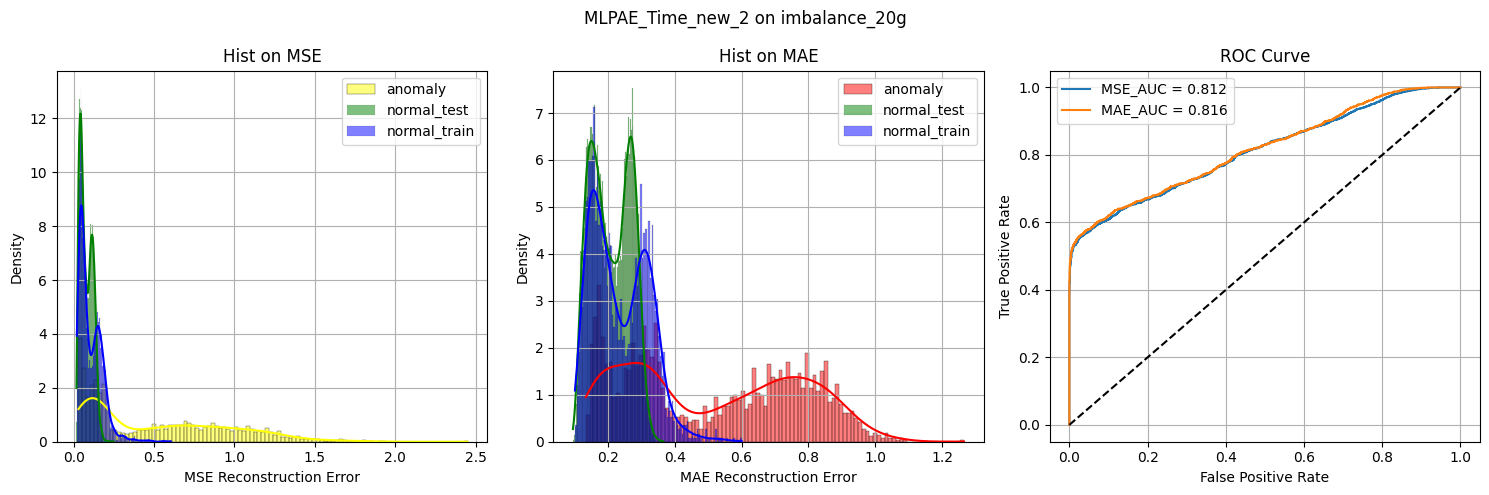

In [81]:
i = np.random.randint(len(df_pred_test))

name = df_pred_test[i, 0]
prime_type = df_pred_test[i, 1]
type_ = df_pred_test[i, 2]
subtype = df_pred_test[i, 3]
channel = df_pred_test[i, 4]

# normal_pred
normal_row = df_pred_test.filter(
    pl.col('model_name') == name,
    pl.col('channel') == channel,
    pl.col('subtype') == 'normal'
)

mse_normal_pred = normal_row[0, mse_cols].to_numpy()
mae_normal_pred = normal_row[0, mae_cols].to_numpy()

mse_normal_pred = mse_normal_pred[np.isfinite(mse_normal_pred)]
mae_normal_pred = mae_normal_pred[np.isfinite(mae_normal_pred)]

fig, ax  = plt.subplots(1, 3, figsize=(15, 5))
mse_vals = df_pred_test[i, mse_cols].to_numpy()
mae_vals = df_pred_test[i, mae_cols].to_numpy()

mse_vals = mse_vals[np.isfinite(mse_vals)]
mae_vals = mae_vals[np.isfinite(mae_vals)]

mae_normal = df_pred_normal[f'{name}_{channel}_MAE'].to_numpy()
mse_normal = df_pred_normal[f'{name}_{channel}_MSE'].to_numpy()

sns.histplot(mse_vals, bins=100, kde=True, stat="density", color='yellow', ax=ax[0], alpha=0.5, label='anomaly')
sns.histplot(mae_vals, bins=100, kde=True, stat="density", color='red', ax=ax[1], alpha=0.5, label='anomaly')

sns.histplot(mse_normal, bins=100, kde=True, stat="density", color='green', ax=ax[0], alpha=0.5, label='normal_test')
sns.histplot(mae_normal, bins=100, kde=True, stat="density", color='green', ax=ax[1], alpha=0.5, label='normal_test')

sns.histplot(mse_normal_pred, bins=100, kde=True, stat="density", color='blue', ax=ax[0], alpha=0.5, label='normal_train')
sns.histplot(mae_normal_pred, bins=100, kde=True, stat="density", color='blue', ax=ax[1], alpha=0.5, label='normal_train')

ax[0].set(title='Hist on MSE', xlabel='MSE Reconstruction Error')
ax[1].set(title='Hist on MAE', xlabel='MAE Reconstruction Error')

ax[0].grid()
ax[1].grid()

ax[0].legend()
ax[1].legend()



y_true_mse = np.concatenate([
    np.zeros_like(mse_normal_pred),
    np.ones_like(mse_vals)
])

y_score_mse = np.concatenate([
    mse_normal_pred,
    mse_vals
])

# ROC
fpr_mse, tpr_mse, thresholds_roc = roc_curve(y_true_mse, y_score_mse)
roc_auc_mse = auc(fpr_mse, tpr_mse)

y_true_mae = np.concatenate([
    np.zeros_like(mae_normal_pred),
    np.ones_like(mae_vals)
])

y_score_mae = np.concatenate([
    mae_normal_pred,
    mae_vals
])

# ROC
fpr_mse, tpr_mse, thresholds_roc = roc_curve(y_true_mse, y_score_mse)
roc_auc_mse = auc(fpr_mse, tpr_mse)

fpr_mae, tpr_mae, thresholds_roc = roc_curve(y_true_mae, y_score_mae)
roc_auc_mae = auc(fpr_mae, tpr_mae)

ax[2].plot(fpr_mse, tpr_mse, label=f"MSE_AUC = {roc_auc_mse:.3f}")
ax[2].plot(fpr_mae, tpr_mae, label=f"MAE_AUC = {roc_auc_mae:.3f}")
ax[2].plot([0, 1], [0, 1], 'k--')
ax[2].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve")
ax[2].legend()
ax[2].grid()

if prime_type == 'mafaulda':
    fig.suptitle(f'{name}_{channel} on {type_}_{subtype}')
    fig.savefig(f'../pictures/MAFAULDA/pred_hist/{name}_Ch{channel}_anom_{type_}_{subtype}.png')
elif prime_type == 1:
    fig.suptitle(f'{name}_{channel} on {subtype}')
else:
    fig.suptitle(f'{name}_{channel} on {prime_type}_{type_}_{subtype}')
    fig.savefig(f'../pictures/MAFAULDA/pred_hist/{name}_Ch{channel}_anom_{prime_type}_{type_}_{subtype}.png')

fig.tight_layout()
plt.show()

In [11]:
mse_cols = [col for col in df_pred_test.columns if 'mse' in col]
mae_cols = [col for col in df_pred_test.columns if 'mae' in col]
# ---- PRECACHE ----

# Pre-extract meta and matrices
mse_mat = df_pred_test[mse_cols].to_numpy()
mae_mat = df_pred_test[mae_cols].to_numpy()
meta = df_pred_test.select(['model_name','prime_type','type','subtype','channel']).to_numpy()

# Make map for normal_pred rows
normal_pred_map = {
    (meta[i,0], meta[i,4]): (mse_mat[i], mae_mat[i])
    for i in range(len(df_pred_test))
    if meta[i,3] == 'normal'
}

# Convert df_pred_normal once
normal_dict = {
    col: df_pred_normal[col].to_numpy()
    for col in df_pred_normal.columns
}


# ---- LOOP ----
for i in tqdm(range(len(df_pred_test)), desc="Перебор ошибок"):
    
    name, prime_type, type_, subtype, channel = meta[i]
    mse_vals = mse_mat[i]
    mae_vals = mae_mat[i]
    
    # normal_pred row (cached)
    mse_normal_pred, mae_normal_pred = normal_pred_map.get((name, channel), (None, None))
    if mse_normal_pred is None:
        continue
    
    # filter inf/nan
    mse_vals = mse_vals[np.isfinite(mse_vals)]
    mae_vals = mae_vals[np.isfinite(mae_vals)]
    mse_normal_pred = mse_normal_pred[np.isfinite(mse_normal_pred)]
    mae_normal_pred = mae_normal_pred[np.isfinite(mae_normal_pred)]

    # normal test
    mse_normal = normal_dict[f"{name}_{channel}_MSE"]
    mae_normal = normal_dict[f"{name}_{channel}_MAE"]

    # ---- PLOTTING ----
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(mse_vals, bins=80, stat="density", color='yellow', ax=ax[0], alpha=0.5, label='anomaly')
    sns.histplot(mse_normal, bins=80, stat="density", color='green', ax=ax[0], alpha=0.5, label='normal_test')
    sns.histplot(mse_normal_pred, bins=80, stat="density", color='blue', ax=ax[0], alpha=0.5, label='normal_train')

    sns.histplot(mae_vals, bins=80, stat="density", color='red', ax=ax[1], alpha=0.5, label='anomaly')
    sns.histplot(mae_normal, bins=80, stat="density", color='green', ax=ax[1], alpha=0.5, label='normal_test')
    sns.histplot(mae_normal_pred, bins=80, stat="density", color='blue', ax=ax[1], alpha=0.5, label='normal_train')

    ax[0].legend()
    ax[1].legend()

    ax[0].grid()
    ax[1].grid()

    # ROC MSE
    y_true = np.concatenate([np.zeros_like(mse_normal_pred), np.ones_like(mse_vals)])
    y_score = np.concatenate([mse_normal_pred, mse_vals])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_mse = auc(fpr, tpr)

    ax[2].plot(fpr, tpr, label=f"AUC MSE={auc_mse:.3f}")

    y_true = np.concatenate([np.zeros_like(mae_normal_pred), np.ones_like(mae_vals)])
    y_score = np.concatenate([mae_normal_pred, mae_vals])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_mae = auc(fpr, tpr)

    ax[2].plot(fpr, tpr, label=f"AUC MSE={auc_mae:.3f}")
    
    ax[2].plot([0, 1], [0, 1], 'k--')
    ax[2].set(title="ROC", xlabel="FPR", ylabel="TPR")
    ax[2].legend()
    ax[2].grid()

    # title
    title = f'{name}_Ch{channel} on {prime_type}_{type_}_{subtype}'
    fig.suptitle(title)

    # save only (no show)
    fig.tight_layout()
    fig.savefig(f'../pictures/MAFAULDA/pred_hist/{name}_Ch{channel}_{prime_type}_{type_}_{subtype}.png')
    plt.close(fig)


Перебор ошибок:   0%|          | 0/104 [00:00<?, ?it/s]

## Метрики по таблицам

In [14]:
import numpy as np
import polars as pl
from tqdm import tqdm
from scipy.stats import ks_2samp
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             precision_recall_curve, accuracy_score)

# ---- ФУНКЦИЯ ДЛЯ РАСЧЕТА МЕТРИК ----
def calculate_metrics(normal_ref, anomaly_val, normal_test_dist):
    """
    normal_ref: массив ошибок на нормальной выборке (train/valid) - для обучения порога/ROC
    anomaly_val: массив ошибок на текущей аномалии - для метрик
    normal_test_dist: массив ошибок на нормальном тесте - для KS теста
    """
    
    # 1. Classification Metrics (ROC, PR, F1...)
    # Формируем вектора для бинарной классификации
    # 0 - норма, 1 - аномалия
    y_true = np.concatenate([np.zeros(len(normal_ref)), np.ones(len(anomaly_val))])
    y_score = np.concatenate([normal_ref, anomaly_val])
    
    # ROC-AUC
    try:
        roc_auc = roc_auc_score(y_true, y_score)
    except ValueError:
        roc_auc = 0.5

    # ROC-PR (Average Precision)
    try:
        pr_auc = average_precision_score(y_true, y_score)
    except ValueError:
        pr_auc = 0.0
        
    # Precision, Recall, F1, Accuracy (Поиск лучшего порога по F1)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)
    
    # Считаем F1 для всех порогов
    # (добавляем epsilon чтобы не делить на 0)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Находим индекс лучшего F1
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]
    
    # Для Accuracy берем порог, соответствующий лучшему F1
    # (thresholds короче на 1 элемент, чем precisions/recalls)
    if best_idx < len(thresholds):
        best_thresh = thresholds[best_idx]
        y_pred = (y_score >= best_thresh).astype(int)
        accuracy = accuracy_score(y_true, y_pred)
    else:
        accuracy = 0.0 # Fallback

    # 2. Statistical Test (KS Test)
    # Сравниваем распределение ошибок Normal Test и Anomaly
    ks_stat, ks_pvalue = ks_2samp(normal_test_dist, anomaly_val)

    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': best_precision,
        'recall': best_recall,
        'f1': best_f1,
        'accuracy': accuracy,
        'ks_stat': ks_stat,
        'ks_pvalue': ks_pvalue
    }

# ---- PRECACHE (из вашего кода) ----
mse_cols = [col for col in df_pred_test.columns if 'mse' in col]
mae_cols = [col for col in df_pred_test.columns if 'mae' in col]

mse_mat = df_pred_test[mse_cols].to_numpy()
mae_mat = df_pred_test[mae_cols].to_numpy()
meta = df_pred_test.select(['model_name','prime_type','type','subtype','channel']).to_numpy()

normal_pred_map = {
    (meta[i,0], meta[i,4]): (mse_mat[i], mae_mat[i])
    for i in range(len(df_pred_test))
    if meta[i,3] == 'normal'
}

normal_dict = {
    col: df_pred_normal[col].to_numpy()
    for col in df_pred_normal.columns
}

# ---- LOOP ----
results = []

# Используем тот же диапазон, что и у вас
for i in tqdm(range(len(df_pred_test)), desc="Генерация метрик"):
    
    name, prime_type, type_, subtype, channel = meta[i]
    mse_vals = mse_mat[i]
    mae_vals = mae_mat[i]
    
    # normal_pred row (cached) - это опорная "норма" (train/valid)
    mse_normal_pred, mae_normal_pred = normal_pred_map.get((name, channel), (None, None))
    
    if mse_normal_pred is None:
        continue
    
    # normal test - это тестовая "норма" для KS теста
    mse_normal_test = normal_dict.get(f"{name}_{channel}_MSE")
    mae_normal_test = normal_dict.get(f"{name}_{channel}_MAE")
    
    if mse_normal_test is None or mae_normal_test is None:
        continue

    # filter inf/nan
    mse_vals = mse_vals[np.isfinite(mse_vals)]
    mae_vals = mae_vals[np.isfinite(mae_vals)]
    
    mse_normal_pred = mse_normal_pred[np.isfinite(mse_normal_pred)]
    mae_normal_pred = mae_normal_pred[np.isfinite(mae_normal_pred)]
    
    mse_normal_test = mse_normal_test[np.isfinite(mse_normal_test)]
    mae_normal_test = mae_normal_test[np.isfinite(mae_normal_test)]

    # --- Calculation ---
    
    # MSE Metrics
    mse_res = calculate_metrics(mse_normal_pred, mse_vals, mse_normal_test)
    
    # MAE Metrics
    mae_res = calculate_metrics(mae_normal_pred, mae_vals, mae_normal_test)
    
    # Construct Row
    row = {
        'model_name': name,
        'channel': channel,
        'prime_type': prime_type,
        'type': type_,
        'subtype': subtype,
        
        # MSE Cols
        'mse_roc_auc': mse_res['roc_auc'],
        'mse_pr_auc': mse_res['pr_auc'],
        'mse_precision': mse_res['precision'],
        'mse_recall': mse_res['recall'],
        'mse_f1': mse_res['f1'],
        'mse_accuracy': mse_res['accuracy'],
        'mse_ks_stat': mse_res['ks_stat'],
        'mse_ks_pvalue': mse_res['ks_pvalue'],
        
        # MAE Cols
        'mae_roc_auc': mae_res['roc_auc'],
        'mae_pr_auc': mae_res['pr_auc'],
        'mae_precision': mae_res['precision'],
        'mae_recall': mae_res['recall'],
        'mae_f1': mae_res['f1'],
        'mae_accuracy': mae_res['accuracy'],
        'mae_ks_stat': mae_res['ks_stat'],
        'mae_ks_pvalue': mae_res['ks_pvalue'],
    }
    
    results.append(row)

# ---- RESULT DATAFRAME ----
df_metrics = pl.DataFrame(results)

# Вывод первых строк для проверки
print(df_metrics.head())


df_metrics.write_csv("../predictions/anomaly_metrics.csv")

Генерация метрик: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:06<00:00, 76.82it/s]

shape: (5, 21)
┌────────────┬─────────┬────────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ model_name ┆ channel ┆ prime_type ┆ type      ┆ … ┆ mae_f1   ┆ mae_accur ┆ mae_ks_st ┆ mae_ks_pv │
│ ---        ┆ ---     ┆ ---        ┆ ---       ┆   ┆ ---      ┆ acy       ┆ at        ┆ alue      │
│ str        ┆ i64     ┆ str        ┆ str       ┆   ┆ f64      ┆ ---       ┆ ---       ┆ ---       │
│            ┆         ┆            ┆           ┆   ┆          ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ ConvAE_FFT ┆ 2       ┆ mafaulda   ┆ horizonta ┆ … ┆ 0.682382 ┆ 0.559854  ┆ 0.294125  ┆ 2.4822e-1 │
│ _new       ┆         ┆            ┆ l-misalig ┆   ┆          ┆           ┆           ┆ 58        │
│            ┆         ┆            ┆ nment     ┆   ┆          ┆           ┆           ┆           │
│ ConvAE_FFT ┆ 2       ┆ mafaulda   ┆ horizonta ┆ … ┆ 0.666667 ┆ 0.5       ┆

In [48]:
df_metrics.filter(pl.col('channel') == 2).group_by(['model_name', 'channel']).agg(pl.col('mse_ks_pvalue').max()).sort(['mse_ks_pvalue'], descending=True)

model_name,channel,mse_ks_pvalue
str,i64,f64
"""ConvAE_Time_new""",2,0.942073
"""ConvBiLSTMAE_Time_new""",2,0.921453
"""ConvBiLSTMAE_FFT_new""",2,0.813038
"""ConvAE_FFT_new""",2,0.001759
"""MLPAE_Time_new""",2,1.2881e-32
"""MLPAE_FFT_new""",2,2.8068e-195


## Генерация таблиц

In [13]:
def collect_metrics(dict_, model, window_size, stride, channels, mode, normal_errors_dict, scaler, 
                    results_list, model_name, rel_path='', device='cpu'):
    """
    Рекурсивная функция для расчета табличных метрик (ROC AUC, PR AUC, MSE, MAE)
    без построения графиков.
    """
    for key, val in dict_.items():
        if key == 'files':
            # --- Формируем "умное" имя датасета (Тип дефекта / Спецификация) ---
            # Берем последние две части пути. Например: '.../imbalance/20g' -> 'imbalance/20g'
            path_parts = os.path.normpath(rel_path).split(os.sep)
            if len(path_parts) >= 2:
                dataset_name = f"{path_parts[-2]}/{path_parts[-1]}"
            else:
                dataset_name = os.path.basename(rel_path)

            # Создаем датасет
            ds_test = MAFAULDADataset(
                [os.path.join(rel_path, f) for f in dict_[key]], 
                window_size, stride, channels, mode=mode, subset='test', 
                split_ratios=[0.7, 0.9], scaler=scaler
            )
            
            # Пропускаем пустые папки
            if len(ds_test) == 0:
                break
                
            dl_test = DataLoader(ds_test, batch_size=512, shuffle=False)
            
            # 1. Считаем ошибки (MSE и MAE)
            # (Используем ту же функцию get_reconstruction_errors, что определили ранее)
            current_errors_dict = get_reconstruction_errors(model, dl_test, device=device)
            
            if len(current_errors_dict['mse']) == 0:
                break

            # --- СБОР МЕТРИК ---
            record = {
                'Model': model_name,
                'Mode': mode,
                'Channels': str(channels),
                'Dataset': dataset_name,     # <-- Исправленное имя (imbalance/20g)
                'Full_Path': rel_path,
                'Count_Normal': len(normal_errors_dict['mse']),
                'Count_Anomaly': len(current_errors_dict['mse'])
            }

            # Считаем метрики для MSE и MAE
            for metric_type in ['mse', 'mae']:
                norm_err = normal_errors_dict[metric_type]
                curr_err = current_errors_dict[metric_type]
                
                # Метки: 0 - норма, 1 - аномалия
                y_true = np.concatenate([np.zeros(len(norm_err)), np.ones(len(curr_err))])
                y_scores = np.concatenate([norm_err, curr_err])
                
                # ROC AUC
                fpr, tpr, _ = roc_curve(y_true, y_scores)
                roc_val = auc(fpr, tpr)
                
                # PR AUC (Average Precision) - важно при дисбалансе классов
                pr_val = average_precision_score(y_true, y_scores)
                
                # Средние значения ошибок
                mean_norm = np.mean(norm_err)
                mean_anom = np.mean(curr_err)

                # Записываем в словарь
                prefix = metric_type.upper() # MSE или MAE
                record[f'{prefix}_ROC_AUC'] = roc_val
                record[f'{prefix}_PR_AUC'] = pr_val
                record[f'{prefix}_Mean_Norm'] = mean_norm
                record[f'{prefix}_Mean_Anom'] = mean_anom

            # Добавляем строку в общий список
            results_list.append(record)
            break 
            
        elif key != 'lf':
            # Рекурсивный проход
            collect_metrics(
                dict_=dict_[key], 
                model=model, 
                window_size=window_size, 
                stride=stride, 
                channels=channels, 
                mode=mode, 
                normal_errors_dict=normal_errors_dict, 
                scaler=scaler, 
                results_list=results_list,
                model_name=model_name,
                rel_path=os.path.join(rel_path, key), 
                device=device
            )

In [14]:
all_results = [] # Список д
DEVICE = 'cpu'

models_config = {
    'MLPAE_FFT': {"channels" : [[2], [5]], "mode" : 'fft', "model_paths" : ['../weights/MLP_fft_Ch2.pt', '../weights/MLP_fft_Ch5.pt'], "class": MLPAutoencoder},
    'MLPAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/MLP_Time_Ch2.pt', '../weights/MLP_Time_Ch5.pt'], "class": MLPAutoencoder},
    'ConvAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvAE_Ch2.pt', '../weights/ConvAE_Ch5.pt'], "class": ConvAutoencoder},
    'ConvBiLSTMAE_Time': {"channels" : [[2], [5]], "mode" : 'time', "model_paths" : ['../weights/ConvBiLSTM_Ch2.pt', '../weights/ConvBiLSTM_Ch5.pt'], "class": ConvBiLSTMAutoencoder}
}
DEVICE = 'cpu'
WINDOW_SIZE = 1024
STRIDE = 512

print(f"Starting evaluation on {DEVICE}...")

for cfg_name, cfg in tqdm(models_config.items(), desc='Models Loop'):
    for ch, path in zip(cfg['channels'], cfg['model_paths']):
        
        # 1. Загрузка модели
        try:
            # Инициализируем класс модели
            model = load_model_full(path, cfg['class'])
            model.to(DEVICE)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue

        model_ident = f"{cfg_name}_Ch{ch}" # Удобное имя модели для таблицы
        
        # 2. Подготовка скейлера (на Train части нормы)
        ds_train = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='train', split_ratios=[0.7, 0.9])
        
        # 3. Подготовка Baseline ошибок (на Test части нормы)
        ds_normal = MAFAULDADataset(normal_files, WINDOW_SIZE, STRIDE, ch, mode=cfg['mode'], subset='test', split_ratios=[0.7, 0.9], scaler=ds_train.scaler)
        dl_normal = DataLoader(ds_normal, batch_size=512, shuffle=False)

        # Считаем эталонные ошибки
        normal_errors_dict = get_reconstruction_errors(model, dl_normal, device=DEVICE)

        # 4. Сбор метрик по всем папкам с дефектами
        # Используем новую функцию collect_metrics
        collect_metrics(
            dict_=fault_dirs, 
            model=model, 
            window_size=WINDOW_SIZE, 
            stride=STRIDE, 
            channels=ch, 
            mode=cfg['mode'], 
            normal_errors_dict=normal_errors_dict, 
            scaler=ds_train.scaler,
            results_list=all_results,  # Сюда падают результаты
            model_name=model_ident, 
            rel_path=DATA_PATH, 
            device=DEVICE
        )

# --- Формирование DataFrame ---
df = pd.DataFrame(all_results)

# Красивая сортировка колонок
desired_order = [
    'Model', 'Mode', 'Channels', 'Dataset', 
    'MSE_ROC_AUC', 'MSE_PR_AUC', 'MSE_Mean_Norm', 'MSE_Mean_Anom',
    'MAE_ROC_AUC', 'MAE_PR_AUC', 'MAE_Mean_Norm', 'MAE_Mean_Anom',
    'Count_Normal', 'Count_Anomaly'
]
# Оставляем только существующие колонки
final_cols = [c for c in desired_order if c in df.columns]
df = df[final_cols]

# Вывод и сохранение
print(f"\nCollected {len(df)} records.")
print(df.head())

df.to_csv('final_metrics_comparison.csv', index=False)
print("Table saved to final_metrics_comparison.csv")

Starting evaluation on cpu...


Models Loop:   0%|          | 0/4 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (513,), 'latent_dim': 192, 'hidden_dims': [512, 256], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 192, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'input_shape': (1, 1024), 'latent_dim': 192, 'hidden_dims': [1024, 512], 'dropout': 0.05, 'batchnorm': True, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 32}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 1024, 'latent_dim': 32}


Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/3 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/2 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/4 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]

Вычисление ошибок:   0%|          | 0/5 [00:00<?, ?it/s]


Collected 336 records.
              Model Mode Channels                        Dataset  MSE_ROC_AUC  \
0  MLPAE_Time_Ch[2]  fft      [2]  horizontal-misalignment/0.5mm     0.946179   
1  MLPAE_Time_Ch[2]  fft      [2]  horizontal-misalignment/1.0mm     0.865809   
2  MLPAE_Time_Ch[2]  fft      [2]  horizontal-misalignment/1.5mm     0.968107   
3  MLPAE_Time_Ch[2]  fft      [2]  horizontal-misalignment/2.0mm     0.998821   
4  MLPAE_Time_Ch[2]  fft      [2]                  imbalance/10g     0.818381   

   MSE_PR_AUC  MSE_Mean_Norm  MSE_Mean_Anom  MAE_ROC_AUC  MAE_PR_AUC  \
0    0.947998       0.476547       0.850657     0.966730    0.967265   
1    0.856828       0.476547       0.579349     0.904127    0.902717   
2    0.970952       0.476547       0.761154     0.978289    0.980981   
3    0.998895       0.476547       1.098032     0.999503    0.999522   
4    0.802728       0.476547       0.561376     0.880236    0.874312   

   MAE_Mean_Norm  MAE_Mean_Anom  Count_Normal  Count_Ano

In [51]:
pl.read_csv('final_metrics_comparison.csv')['Model'].unique()

Model
str
"""MLPAE_Time_Ch[2]"""
"""ConvBiLSTMAE_Time_Ch[2]"""
"""MLPAE_FFT_Ch[5]"""
"""ConvBiLSTMAE_Time_Ch[5]"""
"""ConvAE_Time_Ch[5]"""
"""MLPAE_Time_Ch[5]"""
"""ConvAE_Time_Ch[2]"""
"""MLPAE_FFT_Ch[2]"""


In [68]:
pl.scan_csv(os.path.join(DATA_PATH, 'mafaulda/normal/*.csv'), has_header=False)

# MORE

In [8]:
import pandas as pd

df = pd.read_csv('final_metrics_comparison.csv')

# Простая замена MLPAE_FFT ↔ MLPAE_Time
df["Model"] = (df["Model"]
    .str.replace("MLPAE_FFT", "__TMP__")
    .str.replace("MLPAE_Time", "MLPAE_FFT")
    .str.replace("__TMP__", "MLPAE_Time")
)

df.to_csv('final_metrics_comparison_alt.csv', index=False)

In [9]:
df = pl.read_csv('final_metrics_comparison_alt.csv')
df

Model,Mode,Channels,Dataset,MSE_ROC_AUC,MSE_PR_AUC,MSE_Mean_Norm,MSE_Mean_Anom,MAE_ROC_AUC,MAE_PR_AUC,MAE_Mean_Norm,MAE_Mean_Anom,Count_Normal,Count_Anomaly
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""MLPAE_FFT_Ch[2]""","""fft""","""[2]""","""horizontal-misalignment/0.5mm""",0.946179,0.947998,0.476547,0.850657,0.96673,0.967265,0.5228173,0.640813,2303,2350
"""MLPAE_FFT_Ch[2]""","""fft""","""[2]""","""horizontal-misalignment/1.0mm""",0.865809,0.856828,0.476547,0.579349,0.904127,0.902717,0.5228173,0.5857893,2303,2303
"""MLPAE_FFT_Ch[2]""","""fft""","""[2]""","""horizontal-misalignment/1.5mm""",0.968107,0.970952,0.476547,0.761154,0.978289,0.980981,0.5228173,0.6464639,2303,2303
"""MLPAE_FFT_Ch[2]""","""fft""","""[2]""","""horizontal-misalignment/2.0mm""",0.998821,0.998895,0.476547,1.0980324,0.999503,0.999522,0.5228173,0.732837,2303,2303
"""MLPAE_FFT_Ch[2]""","""fft""","""[2]""","""imbalance/10g""",0.818381,0.802728,0.476547,0.5613761,0.880236,0.874312,0.5228173,0.5803568,2303,2256
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ConvBiLSTMAE_Time_Ch[5]""","""time""","""[5]""","""vertical-misalignment/0.63mm""",0.719595,0.693725,0.007125,0.023724,0.73899,0.701943,0.0597406,0.073311,2303,2350
"""ConvBiLSTMAE_Time_Ch[5]""","""time""","""[5]""","""vertical-misalignment/1.27mm""",0.605921,0.58467,0.007125,0.007916,0.618953,0.584214,0.0597406,0.062528,2303,2350
"""ConvBiLSTMAE_Time_Ch[5]""","""time""","""[5]""","""vertical-misalignment/1.40mm""",0.490985,0.520058,0.007125,0.008033,0.504125,0.522813,0.0597406,0.060895,2303,2350


In [20]:
cols = ["MSE_ROC_AUC", "MSE_PR_AUC", "MAE_ROC_AUC", "MAE_PR_AUC"]

cols_1 = ["MSE_ROC_AUC", "MSE_PR_AUC"]
cols_2 = ["MAE_ROC_AUC", "MAE_PR_AUC"]

In [26]:
df_grouped = df.with_columns(
    pl.col('Dataset').str.split('/').list[-2].alias('Defect Type')
).group_by(
    pl.col('Model'), pl.col('Defect Type')
).agg(*[pl.col(col).mean() for col in cols_2])

pdf = df_grouped.sort(['Model', 'Defect Type']).to_pandas()

# pdf.sorted().to_csv('../metric_aio.csv', index=False, float_format="%.3f")

# ─────────────────────────────────────────────
# 2. Генерируем LaTeX таблицу
latex = pdf.to_latex(
    index=False,
    float_format="%.3f",
    longtable=True,
    escape=True
)

# удалить строки с \begingroup и \endgroup
latex = latex.replace(r'\begingroup', '').replace(r'\endgroup', '')

with open("/home/mihalko711/papers/scientifical_research_report/table_/metric_aio_2.tex", "w") as f:
    f.write(latex)

# TF is that?

In [30]:
import torch
import torch.nn as nn
from torchinfo import summary

model = load_model_full('../weights/ConvBiLSTM_fft_new_Ch2.pt', ConvBiLSTMAutoencoder, device='cpu')

# 2. Генерация отчета
# input_size — важный параметр, укажите размерность вашего батча (batch_size, input_dim)
summary(model, input_size=(1,1,513), 
        col_names=["input_size", "output_size", "num_params", "mult_adds"],
        verbose=0, device='cpu')

ℹ️ Загрузка модели с параметрами: {'in_channels': 1, 'window_size': 513, 'latent_dim': 64}


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
ConvBiLSTMAutoencoder                    [1, 1, 513]               [1, 1, 513]               --                        --
├─Sequential: 1-1                        [1, 1, 513]               [1, 64, 65]               --                        --
│    └─Conv1d: 2-1                       [1, 1, 513]               [1, 16, 257]              128                       32,896
│    └─BatchNorm1d: 2-2                  [1, 16, 257]              [1, 16, 257]              32                        32
│    └─LeakyReLU: 2-3                    [1, 16, 257]              [1, 16, 257]              --                        --
│    └─Conv1d: 2-4                       [1, 16, 257]              [1, 32, 129]              2,592                     334,368
│    └─BatchNorm1d: 2-5                  [1, 32, 129]              [1, 32, 129]              64                        64
│    └─L

In [32]:
df = pl.read_csv('../predictions/anomaly_metrics.csv')


model_name,channel,prime_type,type,subtype,mse_roc_auc,mse_pr_auc,mse_precision,mse_recall,mse_f1,mse_accuracy,mse_ks_stat,mse_ks_pvalue,mae_roc_auc,mae_pr_auc,mae_precision,mae_recall,mae_f1,mae_accuracy,mae_ks_stat,mae_ks_pvalue
str,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""0.5mm""",0.698933,0.74948,0.528568,0.956596,0.680903,0.547174,0.302879,4.4469e-168,0.690906,0.727126,0.536847,0.93617,0.682382,0.559854,0.294125,2.4822e-158
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""1.0mm""",0.520025,0.531996,0.5,1.0,0.666667,0.5,0.071772,1.6569e-9,0.520217,0.532739,0.5,1.0,0.666667,0.5,0.076768,8.1427e-11
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""1.5mm""",0.708933,0.729812,0.562692,0.874946,0.684908,0.597482,0.33553,1.3488e-203,0.743086,0.758618,0.604981,0.833261,0.701005,0.644594,0.395641,4.9679e-286
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""2.0mm""",0.845455,0.862216,0.717852,0.824142,0.767334,0.750109,0.544724,0.0,0.86772,0.87936,0.798128,0.777681,0.787772,0.790491,0.587871,0.0
"""ConvAE_FFT_new""",2,"""mafaulda""","""imbalance""","""10g""",0.55753,0.551565,0.494845,1.0,0.662069,0.494845,0.123269,8.9864e-27,0.578837,0.578378,0.494845,1.0,0.662069,0.494845,0.156404,6.4386e-43
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""0.63mm""",0.712947,0.683973,0.619605,0.855319,0.718627,0.661724,0.737492,0.0,0.726795,0.692424,0.628275,0.877447,0.732244,0.675908,0.732569,0.0
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""1.27mm""",0.605175,0.582217,0.505051,1.0,0.671141,0.505051,0.587166,0.0,0.633926,0.596477,0.550505,0.881277,0.677683,0.576617,0.613136,0.0
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""1.40mm""",0.486339,0.498199,0.505599,0.999149,0.671433,0.506125,0.469878,0.0,0.5211,0.513959,0.506144,0.999149,0.671913,0.5072,0.491752,0.0


In [36]:
df.group_by(
    ['type']
    ) \
    .agg(*[pl.col(col).mean() for col in df.columns if 'mae' in col and 'pvalue' not in col])


type,mae_roc_auc,mae_pr_auc,mae_precision,mae_recall,mae_f1,mae_accuracy,mae_ks_stat
str,f64,f64,f64,f64,f64,f64,f64
"""horizontal-misalignment""",0.686181,0.681256,0.608179,0.947902,0.730954,0.632487,0.423334
"""cage_fault""",0.740981,0.752825,0.662319,0.906166,0.747359,0.677583,0.500941
"""imbalance""",0.591218,0.609863,0.570915,0.918493,0.689461,0.581246,0.330176
"""vertical-misalignment""",0.653981,0.663089,0.572538,0.947178,0.70721,0.593838,0.366227
"""mafaulda""",0.5,0.5,0.5,1.0,0.666667,0.5,0.148747
"""outer_race""",0.844235,0.846618,0.769383,0.91913,0.822984,0.785605,0.667522
"""ball_fault""",0.972766,0.977494,0.958212,0.934942,0.945925,0.949444,0.909176


In [42]:
import polars as pl
import pandas as pd

# 1. Выполняем вашу агрегацию
df_agg = df.group_by(['type']).agg(
    *[pl.col(col).mean() for col in df.columns if 'mse' in col and 'pvalue' not in col and 'ks_stat' not in col]
)

# 2. Переименовываем колонки для красоты (убираем 'mae_' и делаем Title Case)
# Словарь для переименования
rename_map = {
    'type': 'Type',
    'mse_roc_auc': 'ROC-AUC',
    'mse_pr_auc': 'PR-AUC',
    'mse_precision': 'Precision',
    'mse_recall': 'Recall',
    'mse_f1': 'F1-Score',
    'mse_accuracy': 'Accuracy'
}

# Применяем переименование
df_agg = df_agg.rename(rename_map)

# 3. Конвертируем в Pandas и генерируем LaTeX
# sort_values нужен, чтобы типы шли по порядку
latex_code = df_agg.to_pandas().set_index('Type').style \
    .format(precision=3) \
    .to_latex(
        hrules=True,              # Использовать booktabs (\toprule и т.д.)
        column_format="l" + "c" * (len(df_agg.columns) - 1), # Выравнивание: l c c c ...
        caption="Сводная таблица метрик (MSE) по типам аномалий",
        label="tab:mse_metrics_by_type",
        position="h!"
    )

print(latex_code)

\begin{table}[h!]
\caption{Сводная таблица метрик (MSE) по типам аномалий}
\label{tab:mse_metrics_by_type}
\begin{tabular}{lcccccc}
\toprule
 & ROC-AUC & PR-AUC & Precision & Recall & F1-Score & Accuracy \\
Type &  &  &  &  &  &  \\
\midrule
outer_race & 0.842 & 0.846 & 0.769 & 0.922 & 0.823 & 0.784 \\
imbalance & 0.589 & 0.608 & 0.567 & 0.923 & 0.688 & 0.577 \\
horizontal-misalignment & 0.679 & 0.677 & 0.601 & 0.947 & 0.726 & 0.625 \\
cage_fault & 0.739 & 0.751 & 0.672 & 0.902 & 0.749 & 0.682 \\
vertical-misalignment & 0.644 & 0.654 & 0.562 & 0.953 & 0.701 & 0.581 \\
ball_fault & 0.970 & 0.975 & 0.953 & 0.935 & 0.943 & 0.946 \\
mafaulda & 0.500 & 0.500 & 0.500 & 1.000 & 0.667 & 0.500 \\
\bottomrule
\end{tabular}
\end{table}



In [64]:
import polars as pl
import pandas as pd

# ---------------------------------------------------------
# 1. Агрегация в Polars (Модель + Канал)
# ---------------------------------------------------------

# Группируем по имени модели И каналу
df_agg = df.group_by(['model_name', 'channel']).agg(
    *[pl.col(col).mean() for col in df.columns 
      if 'mae' in col              # Берем MSE-метрики
      and 'pvalue' not in col      # Убираем p-value
      and 'ks_stat' not in col]    # Убираем KS-статистику
)

# Сортируем: сначала по Модели, потом по F1 (по убыванию)
df_agg = df_agg.sort(['model_name', 'mae_f1'], descending=[False, True])

# ---------------------------------------------------------
# 2. Форматирование в Pandas и генерация LaTeX
# ---------------------------------------------------------

# Словарь для заголовков
rename_map = {
    'model_name': 'Model',
    'channel': 'Channel',
    'mae_roc_auc': 'AUC-ROC',
    'mae_pr_auc': 'AUC-PR',
    'mae_precision': 'Prec.',
    'mae_recall': 'Recall',
    'mae_f1': 'F1',
    'mae_accuracy': 'Acc.'
}

# Подготовка DataFrame
pdf = df_agg.to_pandas().rename(columns=rename_map)

# Устанавливаем мульти-индекс (Модель, Канал), чтобы таблица выглядела красиво сгруппированной
pdf = pdf.set_index(['Model', 'Channel'])

# Настраиваем стили
latex_code = (
    pdf.style
    .format(precision=3)  # Округление до 3 знаков
    # 1. Выделяем МАКСИМУМ жирным (textbf)
    .highlight_max(
        axis=0,  # Сравниваем по колонкам (среди всех моделей)
        props='textbf:--rwrap;' 
    )
    # 2. Выделяем МИНИМУМ нижним подчеркиванием (underline)
    .highlight_min(
        axis=0, 
        props='underline:--rwrap;'
    )
    .to_latex(
        hrules=True,               # Линии booktabs
        caption="Сводная таблица метрик (MSE) по моделям и каналам. "
                "\\textbf{Жирным} выделено лучшее значение, \\underline{подчеркиванием} — худшее.",
        label="tab:model_channel_comparison_mse",
        position="h!",
        column_format="ll" + "c" * len(pdf.columns), # ll для индекса, c для данных
        multirow_align="t",        # Выравнивание названий моделей по верху
        clines="skip-last;data"    # Умные разделители строк
    )
)

print(latex_code)

\begin{table}[h!]
\caption{Сводная таблица метрик (MSE) по моделям и каналам. \textbf{Жирным} выделено лучшее значение, \underline{подчеркиванием} — худшее.}
\label{tab:model_channel_comparison_mse}
\begin{tabular}{llcccccc}
\toprule
 &  & AUC-ROC & AUC-PR & Prec. & Recall & F1 & Acc. \\
Model & Channel &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{ConvAE_FFT_new} & 5 & 0.715 & 0.704 & 0.657 & 0.951 & 0.759 & 0.670 \\
 & 2 & 0.754 & 0.759 & 0.660 & 0.896 & 0.742 & 0.672 \\
\cline{1-8}
\multirow[t]{2}{*}{ConvAE_Time_new} & 5 & 0.759 & 0.747 & 0.732 & 0.951 & 0.813 & 0.756 \\
 & 2 & 0.787 & 0.825 & 0.694 & 0.899 & 0.767 & 0.711 \\
\cline{1-8}
\multirow[t]{2}{*}{ConvBiLSTMAE_FFT_new} & 5 & \underline{0.690} & \underline{0.693} & 0.651 & \textbf{0.968} & 0.756 & 0.651 \\
 & 2 & 0.708 & 0.721 & \underline{0.612} & 0.920 & \underline{0.717} & \underline{0.621} \\
\cline{1-8}
\multirow[t]{2}{*}{ConvBiLSTMAE_Time_new} & 5 & 0.739 & 0.730 & 0.727 & 0.956 & 0.812 & 0.751 \\
 & 2 & 0.772 & 0.8

In [55]:
df = df.filter(~(pl.col("type") == "mafaulda"))

In [56]:
df

model_name,channel,prime_type,type,subtype,mse_roc_auc,mse_pr_auc,mse_precision,mse_recall,mse_f1,mse_accuracy,mse_ks_stat,mse_ks_pvalue,mae_roc_auc,mae_pr_auc,mae_precision,mae_recall,mae_f1,mae_accuracy,mae_ks_stat,mae_ks_pvalue
str,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""0.5mm""",0.698933,0.74948,0.528568,0.956596,0.680903,0.547174,0.302879,4.4469e-168,0.690906,0.727126,0.536847,0.93617,0.682382,0.559854,0.294125,2.4822e-158
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""1.0mm""",0.520025,0.531996,0.5,1.0,0.666667,0.5,0.071772,1.6569e-9,0.520217,0.532739,0.5,1.0,0.666667,0.5,0.076768,8.1427e-11
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""1.5mm""",0.708933,0.729812,0.562692,0.874946,0.684908,0.597482,0.33553,1.3488e-203,0.743086,0.758618,0.604981,0.833261,0.701005,0.644594,0.395641,4.9679e-286
"""ConvAE_FFT_new""",2,"""mafaulda""","""horizontal-misalignment""","""2.0mm""",0.845455,0.862216,0.717852,0.824142,0.767334,0.750109,0.544724,0.0,0.86772,0.87936,0.798128,0.777681,0.787772,0.790491,0.587871,0.0
"""ConvAE_FFT_new""",2,"""mafaulda""","""imbalance""","""10g""",0.55753,0.551565,0.494845,1.0,0.662069,0.494845,0.123269,8.9864e-27,0.578837,0.578378,0.494845,1.0,0.662069,0.494845,0.156404,6.4386e-43
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""0.63mm""",0.712947,0.683973,0.619605,0.855319,0.718627,0.661724,0.737492,0.0,0.726795,0.692424,0.628275,0.877447,0.732244,0.675908,0.732569,0.0
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""1.27mm""",0.605175,0.582217,0.505051,1.0,0.671141,0.505051,0.587166,0.0,0.633926,0.596477,0.550505,0.881277,0.677683,0.576617,0.613136,0.0
"""MLPAE_Time_new""",5,"""mafaulda""","""vertical-misalignment""","""1.40mm""",0.486339,0.498199,0.505599,0.999149,0.671433,0.506125,0.469878,0.0,0.5211,0.513959,0.506144,0.999149,0.671913,0.5072,0.491752,0.0


In [65]:
import polars as pl
import pandas as pd

# Словарь для переименования колонок (универсальный)
def get_rename_map(prefix):
    return {
        'model_name': 'Model',
        'type': 'Type',
        'subtype': 'Subtype',
        f'{prefix}_roc_auc': 'AUC-ROC',
        f'{prefix}_pr_auc': 'AUC-PR',
        f'{prefix}_precision': 'Prec.',
        f'{prefix}_recall': 'Rec.',
        f'{prefix}_f1': 'F1',
        f'{prefix}_accuracy': 'Acc.',
        f'{prefix}_ks_stat': 'KS',
        f'{prefix}_ks_pvalue': 'p-value'
    }

def generate_longtable(df_polars, metric_prefix='mae'):
    # 1. Отбираем колонки (метрики + ключи группировки)
    metric_cols = [col for col in df_polars.columns if metric_prefix in col]
    group_cols = ['model_name', 'type', 'subtype']
    
    # 2. Агрегируем (среднее по типу/подтипу для каждой модели)
    df_agg = df_polars.group_by(group_cols).agg(
        [pl.col(c).mean() for c in metric_cols]
    )
    
    # 3. Конвертируем в Pandas для форматирования
    pdf = df_agg.to_pandas()
    
    # 4. Переименовываем колонки
    rename_map = get_rename_map(metric_prefix)
    pdf = pdf.rename(columns=rename_map)
    
    # 5. Создаем MultiIndex для красивой группировки (Model -> Type -> Subtype)
    pdf = pdf.set_index(['Model', 'Type', 'Subtype']).sort_index()
    
    # 6. Генерируем LaTeX
    # longtable=True позволяет таблице переноситься на следующие страницы
    latex = pdf.style.format(precision=3).to_latex(
        hrules=True,
        clines="skip-last;data", # Умные линии
        multirow_align="t",      # Выравнивание текста в объединенных ячейках
        environment="longtable", # ВАЖНО: используем longtable
        caption=f"Детальная сводка метрик ({metric_prefix.upper()}) по моделям и подтипам дефектов",
        label=f"tab:full_{metric_prefix}_stats",
        column_format="ll l ccccccc" # Выравнивание колонок
    )
    
    return latex

# --- ИСПОЛЬЗОВАНИЕ ---

# 1. Генерируем таблицу для MAE
print("% ========== MAE TABLE ==========")
print(generate_longtable(df, 'mae'))

# 2. Генерируем таблицу для MSE
print("\n% ========== MSE TABLE ==========")
print(generate_longtable(df, 'mse'))

% ========== MAE TABLE ==========
\begin{longtable}{ll l ccccccc}
\caption{Детальная сводка метрик (MAE) по моделям и подтипам дефектов} \label{tab:full_mae_stats} \\
\toprule
 &  &  & AUC-ROC & AUC-PR & Prec. & Rec. & F1 & Acc. & KS & p-value \\
Model & Type & Subtype &  &  &  &  &  &  &  &  \\
\midrule
\endfirsthead
\caption[]{Детальная сводка метрик (MAE) по моделям и подтипам дефектов} \\
\toprule
 &  &  & AUC-ROC & AUC-PR & Prec. & Rec. & F1 & Acc. & KS & p-value \\
Model & Type & Subtype &  &  &  &  &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{11}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{29}{*}{ConvAE_FFT_new} & \multirow[t]{4}{*}{ball_fault} & 0g & 0.934 & 0.948 & 0.899 & 0.875 & 0.887 & 0.887 & 0.793 & 0.000 \\
 &  & 20g & 0.938 & 0.944 & 0.884 & 0.878 & 0.881 & 0.890 & 0.792 & 0.000 \\
 &  & 35g & 0.941 & 0.938 & 0.880 & 0.874 & 0.877 & 0.900 & 0.800 & 0.000 \\
 &  & 6g & 0.941 & 0.954 & 0.912 & 0.891 & 0.900 & 0.901 & 0.8